In [72]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind
import math
import gdown
import pickle

import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels.panel import PanelOLS
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTENC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import ModelCheckpoint

import time
from datetime import datetime
from datetime import timedelta
import ipywidgets as widgets
from IPython.display import display


import warnings
warnings.filterwarnings('ignore')


## Data

In [73]:
# Ads
Ads = pd.read_csv('/Volumes/Samsung_T5/Data/Applied Project/Ads.csv').sort_values(['asin', 'date'])
Ads['date'] = pd.to_datetime(Ads['date'])
# Sales
Sales = pd.read_csv('/Volumes/Samsung_T5/Data/Applied Project/Sales.csv').sort_values(['asin', 'date'])
Sales['date'] = pd.to_datetime(Sales['date'])
Sales = Sales[Sales['date'] <= '2023-01-07']

In [74]:
# Ads performance for each product on specific keyword on specific date
Ads.head()

,country_code,brand_id,keyword,date,parent_asin,asin,overall_rank_organic,min_brand_rank,min_parent_rank,impressions,click,conversions,serp_scraped
0,US,58,batteries for nail gun,2022-03-09,B0000225HZ,B0000225HZ,NaN,NaN,NaN,1.0,1.0,0.0,False
1,US,58,paslode,2022-03-09,B0000225HZ,B0000225HZ,NaN,NaN,NaN,1.0,1.0,0.0,False
2,US,58,paslode battery,2022-03-09,B0000225HZ,B0000225HZ,NaN,NaN,NaN,85.0,2.0,0.0,False
3,US,58,passload charger and battery,2022-03-09,B0000225HZ,B0000225HZ,NaN,NaN,NaN,4.0,1.0,0.0,False
4,US,58,passload nail gun battery,2022-03-09,B0000225HZ,B0000225HZ,NaN,NaN,NaN,1.0,1.0,0.0,False


In [75]:
# Sales performance for each product on specific date
Sales.head()

,asin,vendor_id,country_code,ordering_region,date,total_rev,units_total,attr_rev,attr_units
3707464,099051000X,352.0,US,US,2022-01-02,0.0,0,0.0,0.0
14687426,099051000X,352.0,US,US,2022-01-03,0.0,0,0.0,0.0
14138448,099051000X,352.0,US,US,2022-01-04,0.0,0,0.0,0.0
1422724,099051000X,352.0,US,US,2022-01-05,0.0,0,0.0,0.0
3756906,099051000X,352.0,US,US,2022-01-06,0.0,0,0.0,0.0


# 1 Preparation

In [76]:
Ads_gb_Asin = Ads.groupby('asin')
Sales_gb_Asin = Sales.groupby('asin')

## 1.1 Check How Many Products in Two Data Sets

In [77]:
# Products that have been advertised: 2368
Ads_Asin = Ads['asin'].unique()
# Products that have been sold: 59312
Sale_Asin = Sales['asin'].unique()
# Products that have been sold but not advertised: 56945
No_Ads_Asin = list(set(Sale_Asin) - set(Ads_Asin))

## 1.2 Calculate Price for Each Product
---
Assuming that the price of each product is remains constant, we can calculate the price for each product by dividing the total sales by the total quantity.

In [78]:
Price_Asin = Sales_gb_Asin[['total_rev', 'units_total']].sum()
Price_Asin['price'] = round(Price_Asin['total_rev'] / Price_Asin['units_total'], 2)
Price_Asin = Price_Asin.drop(['total_rev', 'units_total'], axis = 1)

## 1.3 Preliminary Classification
---
Assuming that the products sold in each brand are roughly the same, we can define the classification of each product by fiding the keywords that were advertised moset often in each brand.

In [79]:
# Count the number of unique products associated with each keyword under each brand
Brand_Keywords = Ads.groupby(['brand_id', 'keyword']).apply(lambda x : x['asin'].nunique()).sort_values(ascending=False)
# Select the top 1 keyword for each brand
Brand_Keyword = Brand_Keywords.groupby('brand_id').idxmax().reset_index()
Brand_Keyword['keyword'] = Brand_Keyword.apply(lambda row: row[0][1], axis = 1)
Brand_Keyword = Brand_Keyword[['brand_id', 'keyword']]
Brand_Keyword.head()

,brand_id,keyword
0,2,integrative therapeutics berberine
1,3,pure encapsulations
2,4,douglas laboratories
3,5,thorne
4,11,collagen supplements


In [80]:
# Manually classify 
brands = Ads['brand_id'].unique()
classification = {
    'Health & HouseHold': [2, 3, 4, 5, 11, 12, 15, 16, 20, 30, 44, 58, 294, 334, 374, 375, 380, 393, 401, 403, 406, 426, 440, 452, 453],
    'Electronics': [103, 394, 436],
    'Beautiful & Personal Care': [118, 131, 134, 302, 311, 364, 392, 425, 457, 459, 471, 481],
    'Pet Supplies': [60, 286, 321, 430],
    'Home Product': [38, 40, 87, 346, 347, 348, 356, 364, 384, 386, 437, 442, 458, 498, 518],
    'Clothing, Shoes & Jewelry': [29, 353]}
Classification = pd.DataFrame({'brand_id': brands, 'category': None})
for category, brand_ids in classification.items():
    Classification.loc[Classification['brand_id'].isin(brand_ids), 'category'] = category

## 1.4 Aggregate Ads Information by Product
---
1. Aggregate the ads data by product and date and determine wherther the product is advertised on a specific day or not => `Ads_Agg`
   
2. Find the first date and the last ads date of each product => `ads_delta`
3. Calculate the actual ads days of each product => `ads_actual`

In [81]:
# Aggregate the ads data by product and date
Ads_Agg = Ads.groupby(['asin', 'date'])[['impressions', 'click', 'conversions']].sum().reset_index()
# Merge the ads data with the sales data
    # Filter out the products that have been sold & advertised
    # Keep ['asin', 'date', 'total_rev', 'units_total', 'attr_rev', 'attr_units']
Sales_Temp = Sales[Sales['asin'].isin(Ads_Asin)][['asin', 'date', 'total_rev', 'units_total', 'attr_rev', 'attr_units']]
Ads_Agg = Ads_Agg.merge(Sales_Temp, on = ['asin', 'date'], how = 'right')
# The Ads data were based on clicks, so when there is no click, the product did not have ads that day
Ads_Agg['ads'] = np.where(Ads_Agg['click'] > 0, 1, 0)

In [82]:
Ads_Agg.head()

,asin,date,impressions,click,conversions,total_rev,units_total,attr_rev,attr_units,ads
0,B0000225HZ,2022-01-02,NaN,NaN,NaN,56.99,1,0.0,0.0,0
1,B0000225HZ,2022-01-03,NaN,NaN,NaN,170.97,3,0.0,0.0,0
2,B0000225HZ,2022-01-04,NaN,NaN,NaN,0.00,0,0.0,0.0,0
3,B0000225HZ,2022-01-05,NaN,NaN,NaN,0.00,0,0.0,0.0,0
4,B0000225HZ,2022-01-06,NaN,NaN,NaN,56.99,1,0.0,0.0,0


In [83]:
len(Ads_Agg[Ads_Agg['ads'] == 1]['date'])

293794

### (i) Ads Delta

In [84]:
def find_first_and_last_date(group):
    ads_dates = group[group['ads'] == 1]['date']
    if len(ads_dates) == 0:
        return pd.Series({'a_first_date': None, 'a_last_date': None})
    else:
        first_date = pd.to_datetime(ads_dates.min(), unit='ns').date()
        last_date = pd.to_datetime(ads_dates.max(), unit='ns').date()
        return pd.Series({'a_first_date': first_date, 'a_last_date': last_date})

In [85]:
Ads_SandE = Ads_Agg.groupby('asin').apply(find_first_and_last_date)
Ads_SandE['a_first_date'], Ads_SandE['a_last_date'] = pd.to_datetime(Ads_SandE['a_first_date']), pd.to_datetime(Ads_SandE['a_last_date'])
Ads_SandE['a_delta'] = (Ads_SandE['a_last_date'] - Ads_SandE['a_first_date']).dt.days + 1
Ads_SandE = Ads_SandE.dropna()
Ads_SandE['a_delta'] = Ads_SandE['a_delta'].astype(int)

### (ii) Ads Actual
**Note**: Products might stop ads due to various reasons.

In [86]:
Ads_SandE['a_actual'] = Ads_Agg[Ads_Agg['ads'] == 1].groupby('asin').size()

## 1.5 Aggregate Sales Information by Product

In [87]:
Sales_SandE = pd.DataFrame({'s_first_date': Sales_gb_Asin.date.min(),
                             's_last_date': Sales_gb_Asin.date.max()}, index = Sales_gb_Asin.date.min().index)
Sales_SandE['s_delta'] = (Sales_SandE['s_last_date'] - Sales_SandE['s_first_date']).dt.days + 1

## 1.6 BreakPoint Determination
Find the periods where each product has consecutive periods with and without advertisements

In [88]:
def get_segments(df, asin):
    filtered_df = df[df['asin'] == asin]
    filtered_df['date'] = pd.to_datetime(filtered_df['date']).dt.date
    
    segments = []
    current_segment = []
    current_ads_state = None
    total_days = 0
    
    for index, row in filtered_df.iterrows():
        if row['ads'] != current_ads_state:
            if current_segment:  # Not null
                end_date = row['date'] - timedelta(1)
                days = (end_date - current_segment[0]).days + 1
                segment_type = 'ads' if current_ads_state == 1 else 'no ads'
                current_segment.extend([end_date, segment_type, days])
                
                # Sales
                segment_sales = filtered_df[(filtered_df['date'] >= current_segment[0]) & 
                                            (filtered_df['date'] <= end_date)]['units_total'].sum()
                current_segment.append(segment_sales)
                
                segments.append(tuple(current_segment))
                total_days += days
            
            current_ads_state = row['ads']
            current_segment = [row['date']]
    
    # last segment
    if current_segment:
        end_date = filtered_df['date'].max()
        days = (end_date - current_segment[0]).days + 1
        segment_type = 'ads' if current_ads_state == 1 else 'no ads'
        current_segment.extend([end_date, segment_type, days])
        
        # Sales
        segment_sales = filtered_df[(filtered_df['date'] >= current_segment[0]) & 
                                    (filtered_df['date'] <= end_date)]['units_total'].sum()
        current_segment.append(segment_sales)
        
        segments.append(tuple(current_segment))
        total_days += days
    
    segments.sort(key = lambda x: str(x[0]))
    segments.append(('Total Days', total_days))
    
    columns = ['Start', 'End', 'Segment Type', 'Duration', 'Sales']
    df_segments = pd.DataFrame(segments, columns = columns)
    
    return df_segments

In [89]:
# e.g.
get_segments(Ads_Agg, 'B0000225HZ')

,Start,End,Segment Type,Duration,Sales
0,2022-01-02,2022-03-08,no ads,66.0,164.0
1,2022-03-09,2022-03-21,ads,13.0,133.0
2,2022-03-22,2022-03-28,no ads,7.0,0.0
3,2022-03-29,2022-04-14,ads,17.0,173.0
4,2022-04-15,2022-04-15,no ads,1.0,9.0
5,2022-04-16,2022-04-23,ads,8.0,63.0
6,2022-04-24,2022-04-24,no ads,1.0,5.0
7,2022-04-25,2022-05-14,ads,20.0,244.0
8,2022-05-15,2022-05-17,no ads,3.0,38.0
9,2022-05-18,2022-06-19,ads,33.0,391.0


## 1.7 Ads Sensitivity
We can make a rough assessment of how products respond to advertisements by comparing the average sales quantity when advertisements are present versus when they are not.

In [90]:
SandA_Info = pd.merge(Sales_SandE, Ads_SandE, left_index = True, right_index = True)
SandA_Info.head()

,s_first_date,s_last_date,s_delta,a_first_date,a_last_date,a_delta,a_actual
asin,,,,,,,
B0000225HZ,2022-01-02,2023-01-07,371,2022-03-09,2022-12-08,275,185
B0000225IB,2022-01-02,2023-01-07,371,2022-08-08,2022-11-02,87,21
B00006RGKR,2022-01-02,2023-01-07,371,2022-01-02,2022-08-26,237,100
B0000A1WGL,2022-01-02,2023-01-07,371,2022-01-02,2022-12-25,358,309
B0000AQO11,2022-11-29,2023-01-07,40,2022-11-29,2023-01-07,40,40


In [91]:
'''Ads_Sensitivity = {}
for asin in Ads_Agg.asin.unique():
    # continuous advertising and no data available for the sales when ads are not present
    if asin in SandA_Info[SandA_Info['a_actual'] == SandA_Info['s_delta']].index:
        continue
    group = Ads_Agg.loc[Ads_Agg['asin'] == asin]
    ads_sales = group[group.ads == 1]['units_total'].mean()
    no_ads_sales = group[group.ads == 0]['units_total'].mean()
    
    # some products only have sales during the ads period
    if no_ads_sales != 0:
        sensitivity = (ads_sales - no_ads_sales) / no_ads_sales
    else:
        sensitivity = np.nan
    Ads_Sensitivity[asin] = sensitivity
Ads_Sensitivity = pd.DataFrame.from_dict(Ads_Sensitivity, orient = 'index').rename(columns={0: 'sensitivity'})
    '''

"Ads_Sensitivity = {}\nfor asin in Ads_Agg.asin.unique():\n    # continuous advertising and no data available for the sales when ads are not present\n    if asin in SandA_Info[SandA_Info['a_actual'] == SandA_Info['s_delta']].index:\n        continue\n    group = Ads_Agg.loc[Ads_Agg['asin'] == asin]\n    ads_sales = group[group.ads == 1]['units_total'].mean()\n    no_ads_sales = group[group.ads == 0]['units_total'].mean()\n    \n    # some products only have sales during the ads period\n    if no_ads_sales != 0:\n        sensitivity = (ads_sales - no_ads_sales) / no_ads_sales\n    else:\n        sensitivity = np.nan\n    Ads_Sensitivity[asin] = sensitivity\nAds_Sensitivity = pd.DataFrame.from_dict(Ads_Sensitivity, orient = 'index').rename(columns={0: 'sensitivity'})\n    "

In [92]:
# Ads_Sensitivity.to_csv('/Volumes/Samsung_T5/Data/Applied Project/ads_sensitivity.csv')
Ads_Sensitivity = pd.read_csv('/Volumes/Samsung_T5/Data/Applied Project/ads_sensitivity.csv', index_col = 0)

In [93]:
# -1: no sales during ads period
Ads_Sensitivity

,sensitivity
B0000225HZ,6.326747
B0000225IB,1.411714
B00006RGKR,12.295938
B0000A1WGL,0.761874
B0000AQO13,-0.725191
...,...
B0BLTBJQMX,0.840000
B0BLTCK4B7,2.068027
B0BLZVC6W3,-0.019608
B0BM2J2FVR,0.666667


# 2 Classic DID

## 2.1 Preparation

### (i) Treatment Group
---
- Actual Ads Days / Ads Delta >= 90%
  
- At least 30 days of ads records:  
  a_actual >= 30

- At least 30 days of sales records before the start of advertising:  
  s_first_date + 30 <= a_first_date

- Selecting a 'a_first_date' based on the kdeplot: 2022-03-15 or 2022-10-15

In [94]:
DID_cls_Treatment = SandA_Info[(SandA_Info['a_actual'] / SandA_Info['a_delta'] >= 0.9) &
                               (SandA_Info['a_actual'] >= 30) &
                               ((SandA_Info['a_first_date'] - SandA_Info['s_first_date']).dt.days >= 30)]

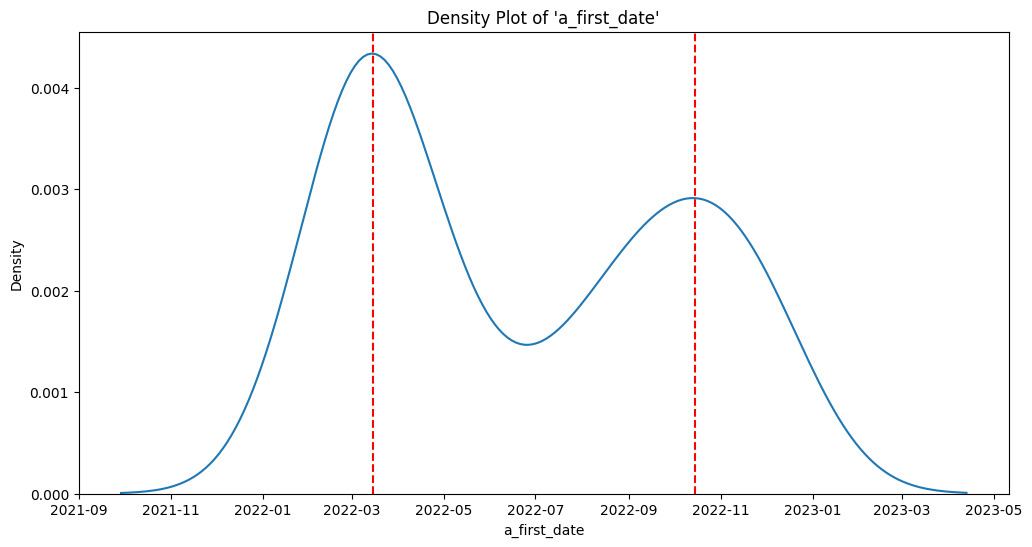

In [95]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data = DID_cls_Treatment['a_first_date'])
plt.xlabel('a_first_date')
plt.ylabel('Density')

plt.axvline(x = datetime.strptime('2022-03-15', '%Y-%m-%d'),
            color = 'red', linestyle = '--')
plt.axvline(x = datetime.strptime('2022-10-15', '%Y-%m-%d'),
            color = 'red', linestyle = '--')
plt.title("Density Plot of 'a_first_date'")
plt.show()

**Note**  
We can choose 2022-03-15 and 2022-10-15 as our 'breakpoint'.

In [96]:
# Select products with a_first_date at around 2022-3
    # Excluding products with a_last_date before 2023-01
DID_cls_Treatment_1 = DID_cls_Treatment[(DID_cls_Treatment['a_first_date'] <= '2022-05-01')&
                                        (DID_cls_Treatment['a_last_date'] >= '2023-01-01')]
# 48 products
DID_cls_Treatment_Asin_1 = DID_cls_Treatment_1.index
# Check category
temp = Ads[Ads['asin'].isin(DID_cls_Treatment_Asin_1)][['brand_id', 'asin']].drop_duplicates()
DID_cls_Treatment_Asin_1_Category = pd.merge(temp, Classification, on = 'brand_id', how = 'left')
# Most of them are in Health & HouseHold, so I will only keep those
# 46 products
DID_cls_Treatment_Asin_1 = DID_cls_Treatment_Asin_1_Category[DID_cls_Treatment_Asin_1_Category['category'] == 'Health & HouseHold'].asin

In [97]:
# Select products with a_first_date at around 2022-10
    # Excluding products with a_last_date before 2023-01
DID_cls_Treatment_2 = DID_cls_Treatment[(DID_cls_Treatment['a_first_date'] <= '2022-12-01') &
                                        (DID_cls_Treatment['a_first_date'] >= '2022-09-01') &
                                        (DID_cls_Treatment['a_last_date'] >= '2023-01-01')]
# 29 products
DID_cls_Treatment_Asin_2 = DID_cls_Treatment_2.index
# Check category
temp = Ads[Ads['asin'].isin(DID_cls_Treatment_Asin_2)][['brand_id', 'asin']].drop_duplicates()
DID_cls_Treatment_Asin_2_Category = pd.merge(temp, Classification, on = 'brand_id', how = 'left')
# Health & HouseHold / Home Product
# 14
DID_cls_Treatment_Asin_2_HH = DID_cls_Treatment_Asin_2_Category[DID_cls_Treatment_Asin_2_Category['category'] == 'Health & HouseHold'].asin
# 13
DID_cls_Treatment_Asin_2_HP = DID_cls_Treatment_Asin_2_Category[DID_cls_Treatment_Asin_2_Category['category'] == 'Home Product'].asin

### (ii) Control Group
---
We chose control group from **Ads** datasets because we only have information such as keywords and brand in this dataset.
- Actual Ads Days / Sales Days <= 5%
- Products in Health & Household / Home Product Category

In [98]:
DID_cls_Control = SandA_Info[(SandA_Info['a_actual'] / SandA_Info['s_delta'] <= 0.05) &
                             (SandA_Info['s_last_date'] >= '2022-12-31')]
DID_cls_Control_Asin = DID_cls_Control.index
temp = Ads[Ads['asin'].isin(DID_cls_Control_Asin)][['brand_id', 'asin']].drop_duplicates()
DID_cls_Control_Asin_Category = pd.merge(temp, Classification, on = 'brand_id', how = 'left')
# 210 products
DID_cls_Control_Asin_HH = DID_cls_Control_Asin_Category[(DID_cls_Control_Asin_Category['category'] == 'Health & HouseHold')].asin
# 82 products
DID_cls_Control_Asin_HP = DID_cls_Control_Asin_Category[(DID_cls_Control_Asin_Category['category'] == 'Home Product')].asin

In [99]:
# Control Group for Treatment_1
    # Category: Health & HouseHold
DID_cls_Control_1 = DID_cls_Control[DID_cls_Control['s_first_date'] <= '2022-02-01']
DID_cls_Control_1 = DID_cls_Control_1[DID_cls_Control_1.index.isin(DID_cls_Control_Asin_HH)]
# 162 products
DID_cls_Control_Asin_1 = DID_cls_Control_1.index

In [100]:
# Control Group for Treatment_2
DID_cls_Control_2 = DID_cls_Control[DID_cls_Control['s_first_date'] <= '2022-09-01']
    # Category: Health & HouseHold
DID_cls_Control_2_HH = DID_cls_Control_2[DID_cls_Control_2.index.isin(DID_cls_Control_Asin_HH)]
# 206 products
DID_cls_Control_Asin_2_HH = DID_cls_Control_2_HH.index

   # Category: Home Product
DID_cls_Control_2_HP = DID_cls_Control_2[DID_cls_Control_2.index.isin(DID_cls_Control_Asin_HP)]
# 75 products
DID_cls_Control_Asin_2_HP = DID_cls_Control_2_HP.index

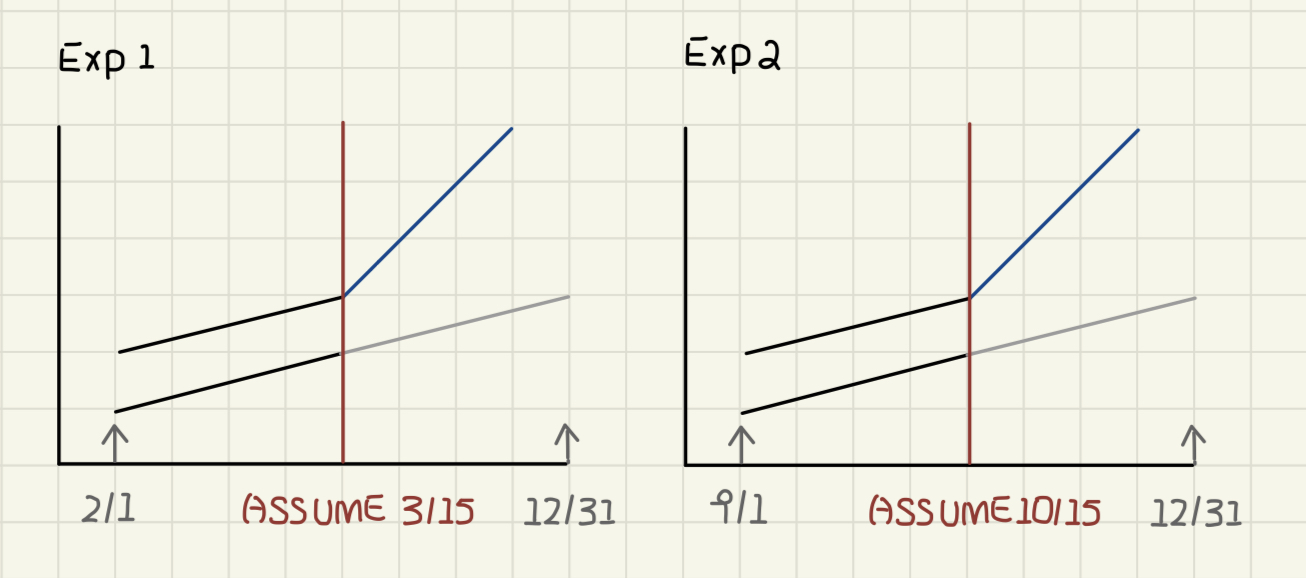

### (iii) Data Aggregation

In [101]:
# Parallel Trend
def plot_parallel_trend(data):
    
    cls_treatment = data[data['treat'] == 1]
    cls_control = data[data['treat'] == 0]
    cls_treatment_before = cls_treatment[cls_treatment['after'] == 0]
    cls_treatment_after = cls_treatment[cls_treatment['after'] == 1]
    cls_control_before = cls_control[cls_control['after'] == 0]
    cls_control_after = cls_control[cls_control['after'] == 1]

    cls_treatment_avg = cls_treatment.groupby('date')['units_total'].mean()
    cls_control_avg = cls_control.groupby('date')['units_total'].mean()
    cls_treatment_before_avg = cls_treatment_before.groupby('date')['units_total'].mean()
    cls_treatment_after_avg = cls_treatment_after.groupby('date')['units_total'].mean()
    cls_control_before_avg = cls_control_before.groupby('date')['units_total'].mean()
    cls_control_after_avg = cls_control_after.groupby('date')['units_total'].mean()

    treatment_before_x = np.arange(len(cls_treatment_before_avg))
    treatment_before_coefficients = np.polyfit(treatment_before_x, cls_treatment_before_avg, 1)
    treatment_before_poly = np.poly1d(treatment_before_coefficients)

    treatment_after_x = np.arange(len(cls_treatment_before_avg), len(cls_treatment_after_avg) + len(cls_treatment_before_avg))
    treatment_after_coefficients = np.polyfit(treatment_after_x, cls_treatment_after_avg, 1)
    treatment_after_poly = np.poly1d(treatment_after_coefficients)

    control_before_x = np.arange(len(cls_control_before_avg))
    control_before_coefficients = np.polyfit(control_before_x, cls_control_before_avg, 1)
    control_before_poly = np.poly1d(control_before_coefficients)

    control_after_x = np.arange(len(cls_control_before_avg), len(cls_control_after_avg) + len(cls_control_before_avg))
    control_after_coefficients = np.polyfit(control_after_x, cls_control_after_avg, 1)
    control_after_poly = np.poly1d(control_after_coefficients)

    treatment_x = np.arange(len(cls_treatment_avg))
    treatment_coefficients = np.polyfit(treatment_x, cls_treatment_avg, 1)
    treatment_poly = np.poly1d(treatment_coefficients)

    control_x = np.arange(len(cls_control_avg))
    control_coefficients = np.polyfit(control_x, cls_control_avg, 1)
    control_poly = np.poly1d(control_coefficients)

    plt.figure(figsize=(15, 3))
    plt.plot(treatment_before_x, treatment_before_poly(treatment_before_x) * 0.4, color='green', linestyle='--')
    plt.plot(treatment_after_x, treatment_after_poly(treatment_after_x) * 0.4, color='green', linestyle='--')
    plt.plot(control_before_x, control_before_poly(control_before_x), color='blue', linestyle='--')
    plt.plot(control_after_x, control_after_poly(control_after_x), color='blue', linestyle='--')
    plt.plot(treatment_x, treatment_poly(treatment_x) * 0.4, color='green', label='treatment')
    plt.plot(control_x, control_poly(control_x), color='blue', label='control')
    plt.legend(loc='upper left')
    plt.title('Parallel Trend')
    plt.xlabel('Time')
    plt.show()


#### a. Experimental 1
- Data Range: 2022-02-01 - 2022-12-31
- BreakPoint: 2022-03-15
- Catgory: Health & HouseHold

In [102]:
DID_cls_df_1 = Sales[Sales['asin'].isin(DID_cls_Treatment_Asin_1) | 
                     Sales['asin'].isin(DID_cls_Control_Asin_1)][['asin', 'date', 'units_total']]
DID_cls_df_1 = DID_cls_df_1[(DID_cls_df_1['date'] >= '2022-02-01') & (DID_cls_df_1['date'] <= '2022-12-31')]
# Flag if in Treatment Group
DID_cls_df_1['treat'] = DID_cls_df_1['asin'].isin(DID_cls_Treatment_Asin_1).astype(int)
# Flag if after 2022-03-15
DID_cls_df_1['after'] = (DID_cls_df_1['date'] >= '2022-03-15').astype(int)

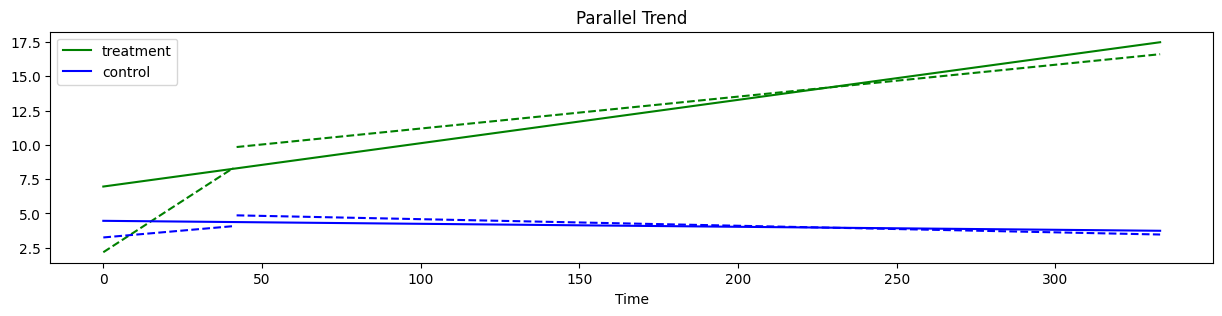

In [103]:
# Parallel Trend
plot_parallel_trend(DID_cls_df_1)

### b. Experimental 2
- Data Range: 2022-09-01 - 2022-12-31
- BreakPoint: 2022-10-15
- Category: Health & HouseHold

In [104]:
DID_cls_df_2_HH = Sales[Sales['asin'].isin(DID_cls_Treatment_Asin_2_HH) | 
                  Sales['asin'].isin(DID_cls_Control_Asin_2_HH)][['asin', 'date', 'units_total']]
DID_cls_df_2_HH = DID_cls_df_2_HH[(DID_cls_df_2_HH['date'] >= '2022-09-01') & (DID_cls_df_2_HH['date'] <= '2022-12-31')]
# Flag if in Treatment Group
DID_cls_df_2_HH['treat'] = DID_cls_df_2_HH['asin'].isin(DID_cls_Treatment_Asin_2_HH).astype(int)
# Flag if after 2022-10-15
DID_cls_df_2_HH['after'] = (DID_cls_df_2_HH['date'] >= '2022-10-15').astype(int)

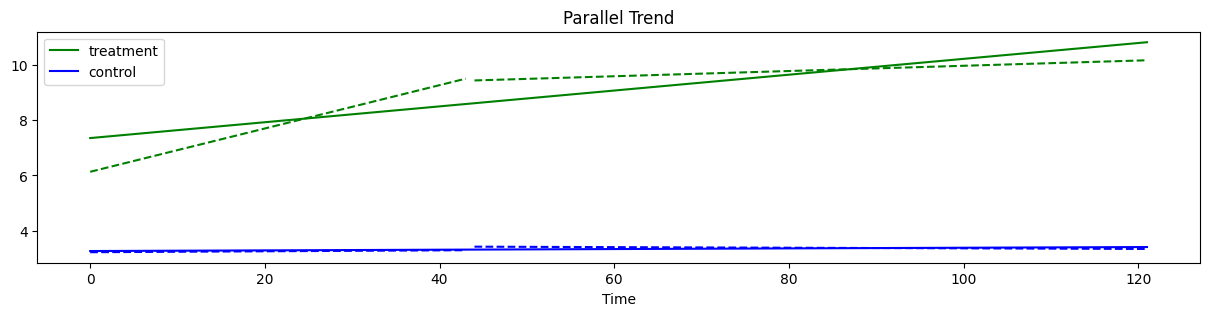

In [105]:
plot_parallel_trend(DID_cls_df_2_HH)

### c. Experimental 3
- Data Range: 2022-09-01 - 2022-12-31
- BreakPoint: 2022-10-15
- Category: Home Product

In [106]:
DID_cls_df_2_HP = Sales[Sales['asin'].isin(DID_cls_Treatment_Asin_2_HP) | 
                  Sales['asin'].isin(DID_cls_Control_Asin_2_HP)][['asin', 'date', 'units_total']]
DID_cls_df_2_HP = DID_cls_df_2_HP[(DID_cls_df_2_HP['date'] >= '2022-09-01') & (DID_cls_df_2_HP['date'] <= '2022-12-31')]
# Flag if in Treatment Group
DID_cls_df_2_HP['treat'] = DID_cls_df_2_HP['asin'].isin(DID_cls_Treatment_Asin_2_HP).astype(int)
# Flag if after 2022-10-15
DID_cls_df_2_HP['after'] = (DID_cls_df_2_HP['date'] >= '2022-10-15').astype(int)

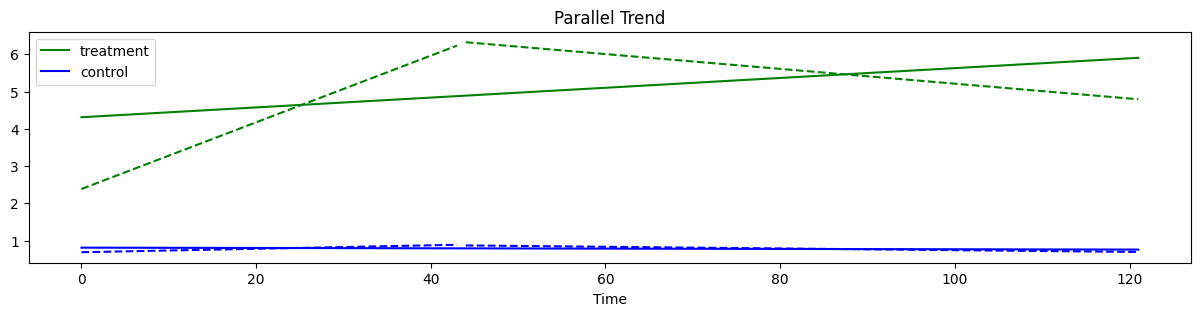

In [107]:
plot_parallel_trend(DID_cls_df_2_HP)

**Note**  
The filtering and processing methods used may be overly simplistic, and thus can only provide a rough approximation and cannot be considered as a definitive conclusion. Given that many products belong to the same category, there might be other factors or variables at play that could introduce uncertainty and confounding effects.

## 2.2 Model

In [108]:
# EXP1: 19.4656***
mod_did_cls_1 = smf.ols('units_total ~ treat*after  +  C(asin)' , data = DID_cls_df_1).fit()
mod_did_cls_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            units_total   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     943.3
Date:                Wed, 14 Jun 2023   Prob (F-statistic):               0.00
Time:                        18:22:16   Log-Likelihood:            -3.3230e+05
No. Observations:               69472   AIC:                         6.650e+05
Df Residuals:                   69261   BIC:                         6.670e+05
Df Model:                         210                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 5.9624      1.619      3.683      0.000       2.790       9.135
C(asin)[T.B00014FSRK]    -3.7118      2.241     -1.656      0.098      -8.105       0.681
C(asin)[T.B00014HNZK]    -4.7807      2.241     -2.133      0.033      -9.174      -0.388
C(asin)[T.B00028N3IG]    -5.9688      2.241     -2.663      0.008     -10.362      -1.576
C(asin)[T.B00028N408]    -4.5706      2.241     -2.039      0.041      -8.964      -0.178
C(asin)[T.B00028N4QC]    -5.1699      2.241     -2.307      0.021      -9.563      -0.777
C(asin)[T.B00028N4R6]    -5.6816      2.241     -2.535      0.011     -10.074      -1.289
C(asin)[T.B00028N69C]    -6.0202      2.241     -2.686      0.007     -10.413      -1.627
C(asin)[T.B00028N7F0]    -5.3430      2.241     -2.384      0.017      -9.736      -0.950
C(asin)[T.B00028NA2A]    -5.7562      2.241     -2.568      0.010     -10.149      -1.363
C(asin)[T.B00028OMMC]    -4.0466      2.241     -1.805      0.071      -8.440       0.346
C(asin)[T.B00028OMPO]    -4.3039      2.241     -1.920      0.055      -8.697       0.089
C(asin)[T.B00028OMWW]     0.6393      2.241      0.285      0.775      -3.754       5.032
C(asin)[T.B00028ONPI]     2.7855      2.241      1.243      0.214      -1.607       7.178
C(asin)[T.B0006SVYAQ]    -6.0890      2.241     -2.717      0.007     -10.482      -1.696
C(asin)[T.B0006SW0YU]    -5.7741      2.241     -2.576      0.010     -10.167      -1.381
C(asin)[T.B0006SW16W]     0.9146      2.241      0.408      0.683      -3.478       5.308
C(asin)[T.B000GBPMFG]    -5.1999      2.241     -2.320      0.020      -9.593      -0.807
C(asin)[T.B000KYKOGG] -1.463e+10   9.85e+10     -0.149      0.882   -2.08e+11    1.78e+11
C(asin)[T.B000KYMBSK] -1.463e+10   9.85e+10     -0.149      0.882   -2.08e+11    1.78e+11
C(asin)[T.B000KYSDEG] -1.463e+10   9.85e+10     -0.149      0.882   -2.08e+11    1.78e+11
C(asin)[T.B000L981X8] -1.463e+10   9.85e+10     -0.149      0.882   -2.08e+11    1.78e+11
C(asin)[T.B000L98250] -1.463e+10   9.85e+10     -0.149      0.882   -2.08e+11    1.78e+11
C(asin)[T.B000L9CBAW] -1.463e+10   9.85e+10     -0.149      0.882   -2.08e+11    1.78e+11
C(asin)[T.B000L9CXGO] -1.463e+10   9.85e+10     -0.149      0.882   -2.08e+11    1.78e+11
C(asin)[T.B000LNOSQI] -1.463e+10   9.85e+10     -0.149      0.882   -2.08e+11    1.78e+11
C(asin)[T.B000LNQ36G] -1.463e+10   9.85e+10     -0.149      0.882   -2.08e+11    1.78e+11
C(asin)[T.B000LNRHXY] -1.463e+10   9.85e+10     -0.149      0.882   -2.08e+11    1.78e+11
C(asin)[T.B000LNRHYS] -1.463e+10   9.85e+10     -0.149      0.882   -2.08e+11    1.78e+11
C(asin)[T.B000MCXT8G]    -5.5111      2.241     -2.459      0.014      -9.904      -1.118
C(asin)[T.B000MD3IV8]    -5.3043      2.241     -2.367      0.018      -9.697      -0.911
C(asin)[T.B000MD3IW2]  

In [109]:
# EXP2: 4.8565***
mod_did_cls_2 = smf.ols('units_total ~ treat*after  +  C(asin)' , data = DID_cls_df_2_HH).fit()
mod_did_cls_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            units_total   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     973.3
Date:                Wed, 14 Jun 2023   Prob (F-statistic):               0.00
Time:                        18:22:18   Log-Likelihood:                -74561.
No. Observations:               26840   AIC:                         1.496e+05
Df Residuals:                   26618   BIC:                         1.514e+05
Df Model:                         221                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 3.9395      0.362     10.882      0.000       3.230       4.649
C(asin)[T.B00014FSRK]    -1.6250      0.505     -3.216      0.001      -2.615      -0.635
C(asin)[T.B00014HNZK]    -0.6987      0.505     -1.383      0.167      -1.689       0.292
C(asin)[T.B00028N3IG]    -3.4612      0.505     -6.851      0.000      -4.451      -2.471
C(asin)[T.B00028N408]    -1.6414      0.505     -3.249      0.001      -2.632      -0.651
C(asin)[T.B00028N4QC]    -2.5922      0.505     -5.131      0.000      -3.582      -1.602
C(asin)[T.B00028N4R6]    -3.1824      0.505     -6.299      0.000      -4.173      -2.192
C(asin)[T.B00028N69C]    -3.5840      0.505     -7.094      0.000      -4.574      -2.594
C(asin)[T.B00028N7F0]    -2.8381      0.505     -5.618      0.000      -3.828      -1.848
C(asin)[T.B00028NA2A]    -3.4365      0.505     -6.802      0.000      -4.427      -2.446
C(asin)[T.B00028OMMC]    -1.6414      0.505     -3.249      0.001      -2.632      -0.651
C(asin)[T.B00028OMPO]    -0.7234      0.505     -1.432      0.152      -1.714       0.267
C(asin)[T.B00028OMWW]     2.2357      0.505      4.425      0.000       1.245       3.226
C(asin)[T.B00028ONPI]     5.9734      0.505     11.823      0.000       4.983       6.964
C(asin)[T.B0006SVYAQ]    -3.6824      0.505     -7.289      0.000      -4.673      -2.692
C(asin)[T.B0006SW0YU]    -3.0840      0.505     -6.104      0.000      -4.074      -2.094
C(asin)[T.B0006SW16W]     2.6947      0.505      5.334      0.000       1.704       3.685
C(asin)[T.B000GBPMFG]    -2.7561      0.505     -5.455      0.000      -3.746      -1.766
C(asin)[T.B000MCXT8G]    -3.2070      0.505     -6.348      0.000      -4.197      -2.217
C(asin)[T.B000MD3IV8]    -2.7643      0.505     -5.472      0.000      -3.755      -1.774
C(asin)[T.B000MD3IW2]    -3.6988      0.505     -7.321      0.000      -4.689      -2.709
C(asin)[T.B000MD3IWW]    -3.9447      0.505     -7.808      0.000      -4.935      -2.954
C(asin)[T.B000MD53J8]    -3.9775      0.505     -7.873      0.000      -4.968      -2.987
C(asin)[T.B000MD53K2]    -3.8217      0.505     -7.565      0.000      -4.812      -2.831
C(asin)[T.B000MDY7RC]    -3.8053      0.505     -7.532      0.000      -4.796      -2.815
C(asin)[T.B000MDY7SQ]    -3.6332      0.505     -7.191      0.000      -4.623      -2.643
C(asin)[T.B000ME1H4W]    -1.9693      0.505     -3.898      0.000      -2.960      -0.979
C(asin)[T.B000NCXZPW]    -3.9939      0.505     -7.905      0.000      -4.984      -3.004
C(asin)[T.B000TDODB0]    -2.9201      0.505     -5.780      0.000      -3.910      -1.930
C(asin)[T.B000TKKJR0]    -3.0021      0.505     -5.942      0.000      -3.992      -2.012
C(asin)[T.B000Z957ZO]    -3.0184      0.505     -5.975      0.000      -4.009      -2.028
C(asin)[T.B001100OTU]  

In [110]:
# EXP3: 3.1307*** 
mod_did_cls_3 = smf.ols('units_total ~ treat*after  +  C(asin)' , data = DID_cls_df_2_HP).fit()
mod_did_cls_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            units_total   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     1028.
Date:                Wed, 14 Jun 2023   Prob (F-statistic):               0.00
Time:                        18:22:20   Log-Likelihood:                -33634.
No. Observations:               10736   AIC:                         6.745e+04
Df Residuals:                   10646   BIC:                         6.810e+04
Df Model:                          89                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.3863      0.517      0.747      0.455      -0.627       1.400
C(asin)[T.B000AR2N44]    -0.0964      0.718     -0.134      0.893      -1.504       1.311
C(asin)[T.B000AR2OB6]     0.1331      0.718      0.185      0.853      -1.274       1.541
C(asin)[T.B000AR2OZ2]     1.1661      0.719      1.622      0.105      -0.243       2.575
C(asin)[T.B000BSB8G6]     4.5351      0.719      6.303      0.000       3.125       5.945
C(asin)[T.B000M9OLAO]  1.927e+10   7.73e+11      0.025      0.980    -1.5e+12    1.53e+12
C(asin)[T.B000MNIB9C]     1.1498      0.719      1.599      0.110      -0.260       2.560
C(asin)[T.B000MS8F2A]  1.927e+10   7.73e+11      0.025      0.980    -1.5e+12    1.53e+12
C(asin)[T.B000VZCPMA]    -0.3504      0.718     -0.488      0.626      -1.759       1.058
C(asin)[T.B0012H6H7A]     2.7149      0.717      3.784      0.000       1.309       4.121
C(asin)[T.B001AHSDQU]     0.9445      0.718      1.316      0.188      -0.462       2.351
C(asin)[T.B001UGGDWW]     1.2154      0.719      1.689      0.091      -0.195       2.626
C(asin)[T.B002KEV4SQ]    -0.3011      0.719     -0.419      0.675      -1.711       1.109
C(asin)[T.B0032OU5JM]  1.927e+10   7.73e+11      0.025      0.980    -1.5e+12    1.53e+12
C(asin)[T.B0035O37DU]  1.927e+10   7.73e+11      0.025      0.980    -1.5e+12    1.53e+12
C(asin)[T.B0038PFCOI]     2.0509      0.717      2.860      0.004       0.645       3.456
C(asin)[T.B0038WTTVS]     9.0757      0.718     12.643      0.000       7.669      10.483
C(asin)[T.B003KWSN04]    -0.3752      0.717     -0.523      0.601      -1.781       1.031
C(asin)[T.B003SXWSXI]     1.7232      0.718      2.402      0.016       0.317       3.130
C(asin)[T.B004IK82XU]    -0.3834      0.718     -0.534      0.593      -1.790       1.023
C(asin)[T.B005XNXG3M]    -0.3834      0.717     -0.534      0.593      -1.790       1.023
C(asin)[T.B005XNXMQ8]     1.7724      0.718      2.469      0.014       0.366       3.179
C(asin)[T.B006L5QGJ2]     0.6495      0.718      0.905      0.366      -0.757       2.056
C(asin)[T.B007N77TNO]    -0.1785      0.717     -0.249      0.803      -1.585       1.227
C(asin)[T.B00BJGOF28]  1.927e+10   7.73e+11      0.025      0.980    -1.5e+12    1.53e+12
C(asin)[T.B00E5N0AKI]    -0.0391      0.718     -0.054      0.957      -1.446       1.368
C(asin)[T.B00E9B05TM]     1.5509      0.717      2.163      0.031       0.145       2.956
C(asin)[T.B00JALSA7A]     1.3626      0.718      1.898      0.058      -0.044       2.770
C(asin)[T.B00JALSFQ6]     1.8954      0.718      2.641      0.008       0.488       3.302
C(asin)[T.B00K1XVJJM]    -0.3260      0.718     -0.454      0.650      -1.733       1.081
C(asin)[T.B00K5DB5G0]    -0.3589      0.717     -0.500      0.617      -1.765       1.047
C(asin)[T.B00K5DBH3G]  

# 3 Staggered DID
---
- Select products which sold from 2022-01-02 to 2022-12-31: 364 days
- For each product, 'ads' = 1 if the products had ads on that day, 0 otherwise

## 3.1 Preparation

In [111]:
# 1602 product
DID_stg_Asin = Sales_SandE[(Sales_SandE.index.isin(Ads_Asin)) & 
                           (Sales_SandE.s_first_date == '2022-01-02') &
                           (Sales_SandE.s_delta >= 364)].index

DID_stg_df = Ads_Agg[(Ads_Agg.asin.isin(DID_stg_Asin)) & 
                     (Ads_Agg.date <= '2022-12-31')][['asin', 'date', 'units_total','total_rev', 'ads']]
DID_stg_df = DID_stg_df.set_index(['asin', 'date'])

## 3.2 Model

In [112]:
PanelOLS.from_formula('units_total ~ ads + EntityEffects', data = DID_stg_df).fit()

Dep. Variable:,units_total,R-squared:,0.0102
Estimator:,PanelOLS,R-squared (Between):,0.0419
No. Observations:,583128,R-squared (Within):,0.0102
Date:,"Wed, Jun 14 2023",R-squared (Overall):,0.0385
Time:,18:22:23,Log-likelihood,-2.522e+06
Cov. Estimator:,Unadjusted,,
,,F-statistic:,5965.3
Entities:,1602,P-value,0.0000
Avg Obs:,364.00,Distribution:,"F(1,581525)"
Min Obs:,364.00,,
Max Obs:,364.00,F-statistic (robust):,5965.3


In [113]:
# Robust:
PanelOLS.from_formula('total_rev ~ ads + EntityEffects', data = DID_stg_df).fit()

Dep. Variable:,total_rev,R-squared:,0.0100
Estimator:,PanelOLS,R-squared (Between):,0.0514
No. Observations:,583128,R-squared (Within):,0.0100
Date:,"Wed, Jun 14 2023",R-squared (Overall):,0.0453
Time:,18:22:25,Log-likelihood,-4.627e+06
Cov. Estimator:,Unadjusted,,
,,F-statistic:,5881.6
Entities:,1602,P-value,0.0000
Avg Obs:,364.00,Distribution:,"F(1,581525)"
Min Obs:,364.00,,
Max Obs:,364.00,F-statistic (robust):,5881.6


# 4 Matching + DID

## 4.1 Information Collection
---
- Through webscraping, we have gathered the **category**, **rating**, and **number of ratings** for each product. In addition, we calculate the **price** (total_rev / sales days) of each product and the **average units sold without advertising**.
- We split the product category into the **first category**, **second category**, and the **last category**.
- We also created **Month Dummy Variables** to indicate whether the product was sold during that month.

## 4.2 Preparation

### (i) Treatment Group
- Drop: the websites for some products are not available.
- Drop: the products were continuously advertised duringg the sales period <=> hard to analyse the effect of ads
- Drop: sales revenue is zero

In [114]:
Treatment_Group = pd.read_csv('/Volumes/Samsung_T5/Data/Applied Project/Treatment_Group.csv').set_index('asin')
Drop1 = Treatment_Group[Treatment_Group['first_category'].isnull()]
Drop2 = Treatment_Group[Treatment_Group.average_units_noads.isnull()]
Drop3 = Treatment_Group[Treatment_Group.Price.isnull()]
Drop = Treatment_Group.index.isin(Drop1.index) | Treatment_Group.index.isin(Drop2.index) | Treatment_Group.index.isin(Drop3.index)
Treatment_Group = Treatment_Group[~Drop]
Treatment_Group.head()

,average_units_noads,Price,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,rating,ratings,first_category,second_category,last_category,sales_days
asin,,,,,,,,,,,,,,,,,,,,
B00014TQ5A,64.420195,33.0,1,1,1,1,1,1,1,1,1,1,1,1,4.8,1654.0,Health & Household,"Vitamins, Minerals & Supplements",B-Complex,371
B08HPKVJXG,14.165746,36.0,1,1,1,1,1,1,1,1,1,1,1,1,4.8,340.0,Health & Household,"Vitamins, Minerals & Supplements",Vitamin C,371
B09CG7C8D4,0.111111,148.0,0,0,0,0,0,0,0,1,1,1,1,1,4.5,100.0,Home & Kitchen,Kitchen & Dining,Skillets,141
B09PC3TTK3,0.173077,21.0,0,0,0,0,0,0,0,0,1,1,1,1,4.9,12.0,"Clothing, Shoes & Jewelry",Women,Socks,107
B001683A34,2.236287,62.0,1,1,1,1,1,1,1,1,1,1,1,1,4.6,50.0,Health & Household,"Vitamins, Minerals & Supplements",Blended Vitamin & Mineral Supplements,371


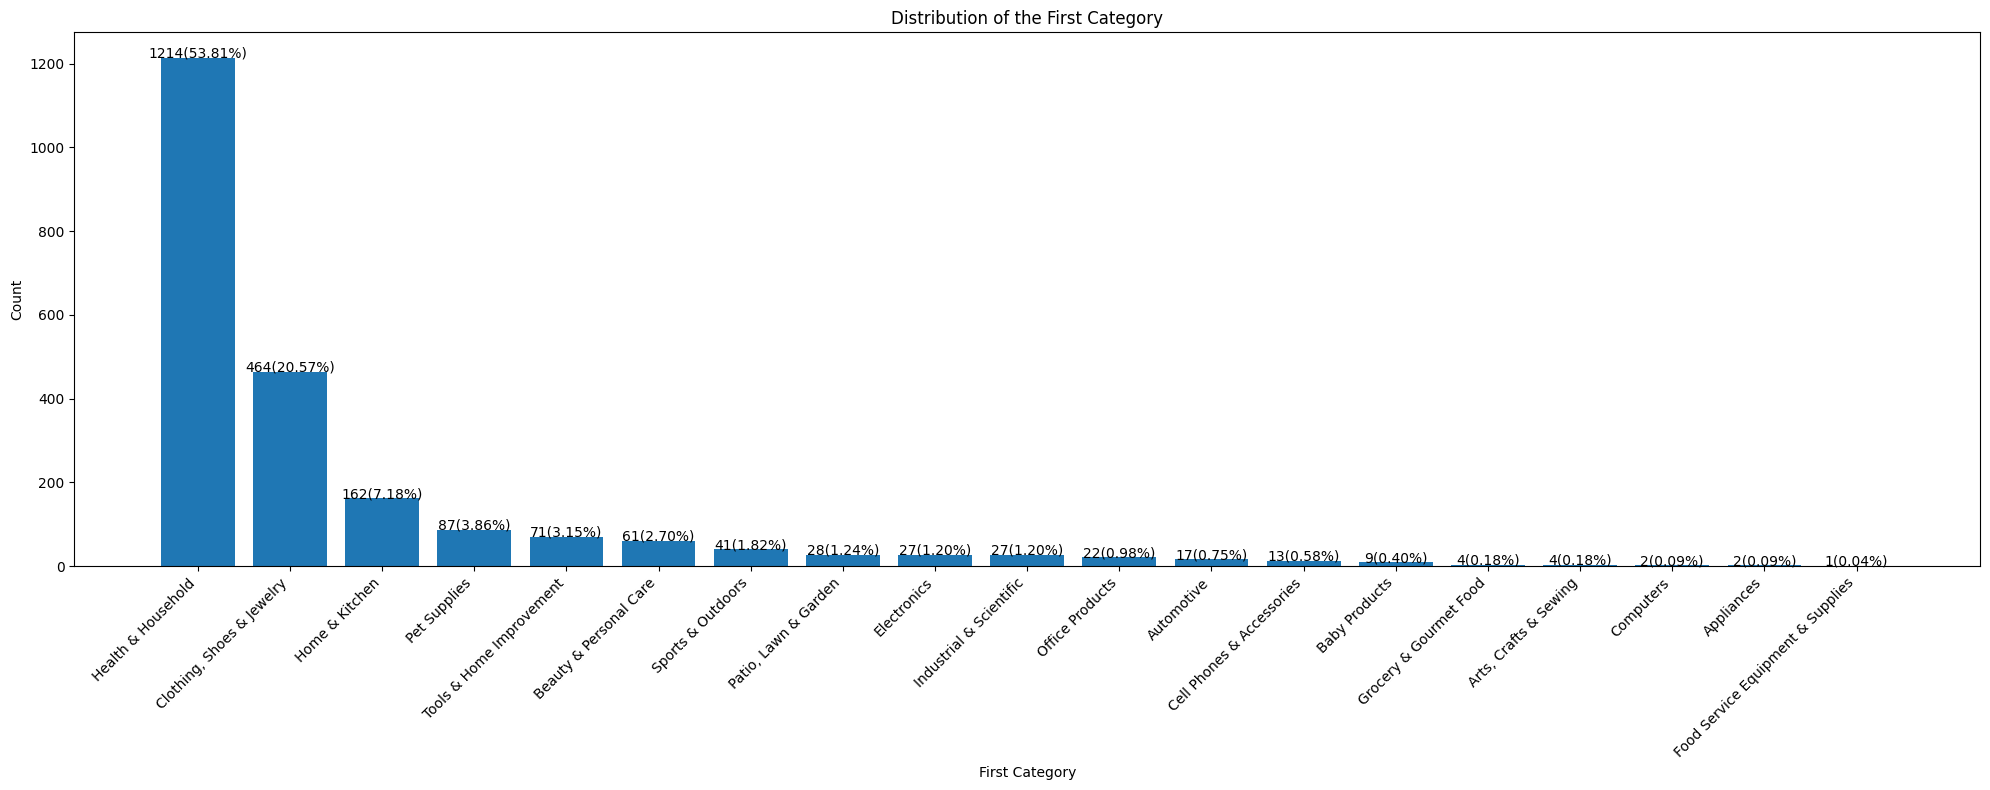

In [115]:
# Overvies the Distribution of the First Category
Categoyr_Counts_Treatment = Treatment_Group['first_category'].value_counts()
plt.figure(figsize = (20,8))
plt.bar(Categoyr_Counts_Treatment.index, Categoyr_Counts_Treatment)
plt.title('Distribution of the First Category')
plt.xlabel('First Category')
plt.ylabel('Count')
plt.xticks(Categoyr_Counts_Treatment.index, rotation = 45, ha = 'right')
for i, count in enumerate(Categoyr_Counts_Treatment):
    plt.text(i, count, f"{count}({count/sum(Categoyr_Counts_Treatment)*100:.2f}%)", ha ='center')
plt.tight_layout()


**Note**  
Based on the findings, we can observe that half of the products belong to the ``Health & Household``. Furthermore, when considering the combined percentage of products in the ``Health & Household``, ``Clothing, Shoes & Jewelry``, and ``Home & Kitchen`` categories, it exceeds 80%.

### (ii) Control Group
- Filter: share the same first_category as the products in the Treatment_Group
- Drop: the websites for some products are not available.

In [116]:
Control_Group = pd.read_csv('/Volumes/Samsung_T5/Data/Applied Project/Control_Group.csv').set_index('asin')
First_Cat_seleced = Treatment_Group.first_category.unique()
Control_Group = Control_Group[Control_Group['first_category'].isin(First_Cat_seleced)]
Control_Group = Control_Group.dropna(subset = ['first_category'])

In [117]:
Control_Group.head()

,average_units_noads,Price,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,rating,ratings,first_category,second_category,last_category,sales_days
asin,,,,,,,,,,,,,,,,,,,,
B081B8YXLF,0.091644,70.0,1,1,1,1,1,1,1,1,1,1,1,1,4.4,18.0,"Clothing, Shoes & Jewelry",Men,Hiking Shoes,371
B09DNCYHBL,0.053571,37.0,0,0,0,0,0,0,0,0,0,0,1,1,4.3,69.0,Home & Kitchen,Home Décor Products,Panels,56
B01KMASISI,0.002695,100.0,1,1,1,1,1,1,1,1,1,1,1,1,4.4,156.0,"Clothing, Shoes & Jewelry",Women,Bangle,371
B07Q5VK4S9,0.183288,47.0,1,1,1,1,1,1,1,1,1,1,1,1,NaN,NaN,Home & Kitchen,Bedding,Pillowcases,371
B0B2JRYC15,0.177419,127.0,0,0,0,0,0,0,0,0,1,1,1,1,4.6,139.0,"Clothing, Shoes & Jewelry",Boot Shop,Snow & Cold Weather,124


## 4.3 Matching

### (i) Preparation

In [118]:
num_features = ['average_units_noads', 'Price', 'rating', 'ratings']
dummy = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

#### a. Evaluation Matching Quality
- Compare whether the distribution of matched samples converge on each feature (num_features)

In [119]:
def check_balance(matched_data, feature):
    
    matched_data = matched_data.dropna()
    
    Treatment_Group[['rating', 'ratings']] = Treatment_Group[['rating', 'ratings']].fillna(0)
    Control_Group[['rating', 'ratings']] = Control_Group[['rating', 'ratings']].fillna(0)
    Treat = Treatment_Group.loc[matched_data['treatment_asin']]
    Control = Control_Group.loc[matched_data['matched_asin']]
    Treat_features = Treat[feature]
    Control_features = Control[feature]
    
    plt.figure(figsize = (15, 6))
    sns.histplot(Treat_features, color = 'orange', label = 'Treatment', kde = True)
    sns.histplot(Control_features, color = 'blue', label = 'Control', kde = True)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend()
    plt.title('Distribution of {} After Matching'.format(feature))
    
    t_stat, p_value = ttest_ind(Treat_features, Control_features)
    print('T-Test Result - {}:'.format(feature))
    print('T-Statistic: {:.4f}'.format(float(t_stat)))
    print('P-Value: {:.4f}'.format(float(p_value)))
    
    if p_value > 0.05:
        print('The feature "{}" shows no significant difference after matching.'.format(feature))
    else:
        print('The feature "{}" shows a significant difference after matching.'.format(feature))
    print('')

#### b. Compare Matched Products' Sales Trend
- Plot two matched products' sales trend

In [120]:
def plot_total_units(asin_treat, asin_control_model, asin_control_manual):
    
    plt.figure(figsize = (30, 8))
    if asin_treat != 'pass':
        t = Ads_Agg
        t = t[t['asin'] == asin_treat]
        plt.plot(t.date, t.units_total, label='treat')
        # mark the advertising time period
        ad_dates = t[t.ads == 1].date
        ad_dates = pd.DatetimeIndex(ad_dates)
        for i in range(len(ad_dates) - 1):
            plt.axvspan(ad_dates[i], ad_dates[i]+timedelta(days = 1), facecolor='gray', alpha=0.3)
        
    # mathed data
    if asin_control_model != 'pass':
        c_model = Sales[Sales['asin'] == asin_control_model].sort_values(by='date')
        plt.plot(c_model.date, c_model.units_total, label='control_model')

    if asin_control_manual != 'pass':
        c_manual = Sales[Sales['asin'] == asin_control_manual].sort_values(by='date')
        plt.plot(c_manual.date, c_manual.units_total, label='control_manual')

    plt.legend()
    plt.title('Total Units with Ad Annotation')
    plt.xlabel('Date')
    plt.ylabel('Total Units')
    plt.show()

#### c. Select Best Matched Product

In [121]:
def calculate_cointegration(asin_treat, data):
    asin_control_model = data[data['treatment_asin'] == asin_treat]['matched_asin_model'].values[0]
    asin_control_manual = data[data['treatment_asin'] == asin_treat]['matched_asin_manual'].values[0]
    
    df_treat = Sales[Sales['asin'] == asin_treat].sort_values(by='date')[['date', 'units_total']]
    df_control_model = Sales[Sales['asin'] == asin_control_model].sort_values(by='date')[['date', 'units_total']]
    df_control_manual = Sales[Sales['asin'] == asin_control_manual].sort_values(by='date')[['date', 'units_total']]
    
    Compare_model = pd.merge(df_treat, df_control_model, on = 'date', suffixes = ('', '_model'))
    Compare_model = pd.merge(Compare_model, Ads_Agg[Ads_Agg['asin'] == asin_treat][['date', 'ads']], on = 'date')
    result_model = sm.tsa.stattools.coint(Compare_model.loc[Compare_model['ads'] == 0, 'units_total'], Compare_model.loc[Compare_model['ads'] == 0, 'units_total_model'])
    
    Compare_manual = pd.merge(df_treat, df_control_manual, on = 'date', suffixes = ('', '_manual'))
    Compare_manual = pd.merge(Compare_manual, Ads_Agg[Ads_Agg['asin'] == asin_treat][['date', 'ads']], on = 'date')
    result_manual = sm.tsa.stattools.coint(Compare_manual.loc[Compare_manual['ads'] == 0, 'units_total'], Compare_manual.loc[Compare_manual['ads'] == 0, 'units_total_manual'])
    if abs(result_model[0]) > abs(result_manual[0]):
        print('model matching is better')
        return asin_control_model, result_model
    elif abs(result_model[0]) < abs(result_manual[0]):
        print('manual matching is better')
        return asin_control_manual, result_manual
    else:
        print('same')
        return asin_control_model, result_model

### (ii) Similarity: Calculated Manually

#### a. Preprocessing

In [122]:
Similarity_Data = pd.concat([Treatment_Group, Control_Group])
# Identify treatment / control
Similarity_Data['treat'] = 0
Similarity_Data.loc[Treatment_Group.index, 'treat'] = 1
# Fill NA in rating and ratings
Similarity_Data[['rating', 'ratings']] = Similarity_Data[['rating', 'ratings']].fillna(0)

# Transformation
    # BoxCox
for feature in num_features:
    transformed_data, lambda_ = stats.boxcox(Similarity_Data[feature] + 1)
    Similarity_Data[feature] = transformed_data
    # MinMax
scaler = MinMaxScaler()
Similarity_Data[num_features] = scaler.fit_transform(Similarity_Data[num_features])

#### b. Treat/Control Split

In [123]:
Treatment_Candidates = Similarity_Data[Similarity_Data.treat == 1]
Control_Candidates = Similarity_Data[Similarity_Data.treat == 0]

#### c. Calculate Similarity Scores and Match Data
- num_features: Linalg
- dummy variables: Jaccard Similarity

In [124]:
# Jaccard Similarity
def jaccard_similarity(set1, set2):
    set1 = set(set1)  
    set2 = set(set2) 
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union)

In [125]:
'''# 5 min
before = time.time()

matched_data_similarity = []

for _, t_row in Treatment_Candidates.iterrows():
    t_sample_num_features = t_row[num_features]
    t_sample_dum_features = t_row[dummy]
    t_sample_last_cat = t_row['last_category']
    t_sample_second_cat = t_row['second_category']
    t_sample_first_cat = t_row['first_category']
    
    min_similarity = np.inf
    best_match_index = None
    
    # select control group candidates that have the same last_category as the t_sample
    control_last_cat = Control_Candidates[Control_Candidates['last_category'] == t_sample_last_cat]
    if not control_last_cat.empty:
        for _, c_row in control_last_cat.iterrows():
            c_sample_num_features = c_row[num_features]
            c_sample_dum_features = c_row[dummy]
            
            similarity1 = np.linalg.norm(t_sample_num_features - c_sample_num_features)
            similarity2 = jaccard_similarity(t_sample_dum_features, c_sample_dum_features)
            similarity = 0.7* similarity1 + 0.3*(1 - similarity2)
            
            if similarity < min_similarity:
                min_similarity = similarity
                best_match_index = c_row.name
                if similarity == 0:
                    break
                    
    if best_match_index is None:
        # select control group candidates that have the same second_category as the t_sample
        control_second_cat = Control_Candidates[Control_Candidates['second_category'] == t_sample_second_cat]
        if not control_second_cat.empty:
            for _, c_row in control_second_cat.iterrows():
                c_sample_num_features = c_row[num_features]
                c_sample_dum_features = c_row[dummy]

                similarity1 = np.linalg.norm(t_sample_num_features - c_sample_num_features)
                similarity2 = jaccard_similarity(t_sample_dum_features, c_sample_dum_features)
                similarity = 0.7* similarity1 + 0.3*(1 - similarity2)
                
                if similarity < min_similarity:
                    min_similarity = similarity
                    best_match_index = c_row.name
                    if similarity == 0:
                        break
    
    if best_match_index is None:
        # select control group candidates that have the same first_category as the t_sample
        control_first_cat = Control_Candidates[Control_Candidates['first_category'] == t_sample_first_cat]
        if not control_first_cat.empty:
            for _, c_row in control_first_cat.iterrows():
                c_sample_num_features = c_row[num_features]
                c_sample_dum_features = c_row[dummy]

                similarity1 = np.linalg.norm(t_sample_num_features - c_sample_num_features)
                similarity2 = jaccard_similarity(t_sample_dum_features, c_sample_dum_features)
                similarity = 0.7* similarity1 + 0.3*(1 - similarity2)
                
                if similarity < min_similarity:
                    min_similarity = similarity
                    best_match_index = c_row.name
                    if similarity == 0:
                        break
    
    matched_data_similarity.append((t_row.name, best_match_index))
        
after = time.time()
time_used = after - before
print("Execution time:", time_used, "seconds")'''

'# 5 min\nbefore = time.time()\n\nmatched_data_similarity = []\n\nfor _, t_row in Treatment_Candidates.iterrows():\n    t_sample_num_features = t_row[num_features]\n    t_sample_dum_features = t_row[dummy]\n    t_sample_last_cat = t_row[\'last_category\']\n    t_sample_second_cat = t_row[\'second_category\']\n    t_sample_first_cat = t_row[\'first_category\']\n    \n    min_similarity = np.inf\n    best_match_index = None\n    \n    # select control group candidates that have the same last_category as the t_sample\n    control_last_cat = Control_Candidates[Control_Candidates[\'last_category\'] == t_sample_last_cat]\n    if not control_last_cat.empty:\n        for _, c_row in control_last_cat.iterrows():\n            c_sample_num_features = c_row[num_features]\n            c_sample_dum_features = c_row[dummy]\n            \n            similarity1 = np.linalg.norm(t_sample_num_features - c_sample_num_features)\n            similarity2 = jaccard_similarity(t_sample_dum_features, c_sample

In [126]:
# Matched_Manual = pd.DataFrame(matched_data_similarity, columns=['treatment_asin', 'matched_asin'])
#Matched_Manual.to_csv('/Volumes/Samsung_T5/Data/Applied Project/Matched_Manual.csv', index = False)
Matched_Manual = pd.read_csv('/Volumes/Samsung_T5/Data/Applied Project/Matched_Manual.csv')

In [127]:
# We don't have these categoris in the Control_Group
# Company; Food Service Equipment & Supplies
Matched_Manual[Matched_Manual.matched_asin.isnull()]

,treatment_asin,matched_asin
57,B07G4M5JM4,NaN
336,B0123X81UC,NaN
484,B005CJKF7C,NaN


### (iii) Similarity: Calculated by Model
---
- Example: Logistic Regression

#### a. Model

In [128]:
def PSM_log(X, y):
    # Grid search for selecting the best model parameters
    param_grid = {
        'C': np.logspace(-6, 3, num = 10), 
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    }
    # Using Logistic Regression to calculate propensity scores
    logreg = LogisticRegression()
    grid_search = GridSearchCV(logreg, param_grid, cv = 5)
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_

    # get propensity scores
    propensity_scores = best_model.predict_proba(X)[:, 1]
    return propensity_scores, best_model

#### b. Calculate the PSM Score and Match Data

In [129]:
def get_matched_data(first_category):

    temp1 = Treatment_Group[Treatment_Group['first_category'] == first_category][num_features + dummy + ['second_category', 'last_category']]
    temp2 = Control_Group[Control_Group['first_category'] == first_category][num_features + dummy + ['second_category', 'last_category']]

    PSM_Data = pd.concat([temp1, temp2])
    
    # Identify treatment / control
    PSM_Data['treat'] = 0
    PSM_Data.loc[temp1.index, 'treat'] = 1
    # Fill NA in rating and ratings
    PSM_Data[['rating', 'ratings']] = PSM_Data[['rating', 'ratings']].fillna(0)
    PSM_Data = PSM_Data.dropna()
    
    # Resample the data
    X = PSM_Data.drop(['treat'], axis = 1)
    y = PSM_Data['treat']
    numeric = X.select_dtypes(['float64', 'int64']).columns
    cat = X.select_dtypes(exclude = ['float64', 'int64']).columns
    cat_indices = [X.columns.get_loc(col) for col in cat]
    smote = SMOTENC(categorical_features = cat_indices)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    # Transformation
        # BoxCox
    for feature in numeric:
        transformed_data, lambda_ = stats.boxcox(X_resampled[feature] + 1)
        X_resampled[feature] = transformed_data
        # StandardScaler
    scaler = StandardScaler()
    X_num_scaled = scaler.fit_transform(X_resampled[numeric])
    X_scaled = pd.DataFrame(X_num_scaled, columns = numeric)
    
    # Get propensity scores ### changing method
    propensity_scores, best_model = PSM_log(X_scaled, y_resampled)
    PSM_Data = PSM_Data.assign(score = list(propensity_scores)[:len(PSM_Data)])
    
    
    # Perform matching: KNN
    matcher = NearestNeighbors(n_neighbors = 1)
    control_candidates = PSM_Data[PSM_Data['treat'] == 0]
    treatment_candidates = PSM_Data[PSM_Data['treat'] == 1]
    
    matched_data = pd.DataFrame(columns=['treatment_asin', 'treatment_second_category', 'treatment_last_category', 'matched_asin', 'matched_second_category', 'matched_last_category'])
    
    for score_idx, score in enumerate(list(treatment_candidates.score)):
        treatment_sample = treatment_candidates.iloc[score_idx]
        
        # select control group candidates that have the same last_category as the t_s
        control_candidates_second = control_candidates[control_candidates['second_category'] == treatment_sample['second_category']]
        if len(control_candidates_second) > 0:
            control_candidates_last = control_candidates_second[control_candidates_second['last_category'] == treatment_sample['last_category']]
            if len(control_candidates_last) > 0:
                matcher.fit(np.array(control_candidates_last['score']).reshape(-1, 1))
                _, nearest_idx = matcher.kneighbors([[score]])
                nearest_control_data = control_candidates_last.iloc[nearest_idx[0][0]]
            else: 
                # if there are no control samples with the same last_category, choose the one that is closest to the treatment sample(same second_category)
                matcher.fit(np.array(control_candidates_second['score']).reshape(-1, 1))
                _, nearest_idx = matcher.kneighbors([[score]])
                nearest_control_data = control_candidates_second.iloc[nearest_idx[0][0]]
        else:
            # if there are no control samples with the same second_category, choose the one that is closest to the treatment sample(same first_category)
            matcher.fit(np.array(control_candidates['score']).reshape(-1, 1))
            _, nearest_idx = matcher.kneighbors([[score]])
            nearest_control_data = control_candidates.iloc[nearest_idx[0][0]]
        
        matched_data = pd.concat([matched_data, pd.DataFrame({
            'treatment_asin': treatment_sample.name,
            'treatment_second_category': treatment_sample['second_category'],
            'treatment_last_category': treatment_sample['last_category'],
            'matched_asin': nearest_control_data.name,
            'matched_second_category': nearest_control_data['second_category'],
            'matched_last_category': nearest_control_data['last_category']
        }, index = [0])], ignore_index = True)
    
    return matched_data, best_model

#### c. Pre-trained Model

##### Health & HouseHold

In [130]:
category = 'Health & Household'
matched_data_HH_lr, best_model_HH_lr = get_matched_data(category)
best_model_HH_lr

LogisticRegression(C=0.0001, solver='liblinear')

T-Test Result - average_units_noads:
T-Statistic: 1.4630
P-Value: 0.1436
The feature "average_units_noads" shows no significant difference after matching.

T-Test Result - Price:
T-Statistic: 1.3699
P-Value: 0.1708
The feature "Price" shows no significant difference after matching.

T-Test Result - rating:
T-Statistic: 5.2444
P-Value: 0.0000
The feature "rating" shows a significant difference after matching.

T-Test Result - ratings:
T-Statistic: 0.7887
P-Value: 0.4304
The feature "ratings" shows no significant difference after matching.



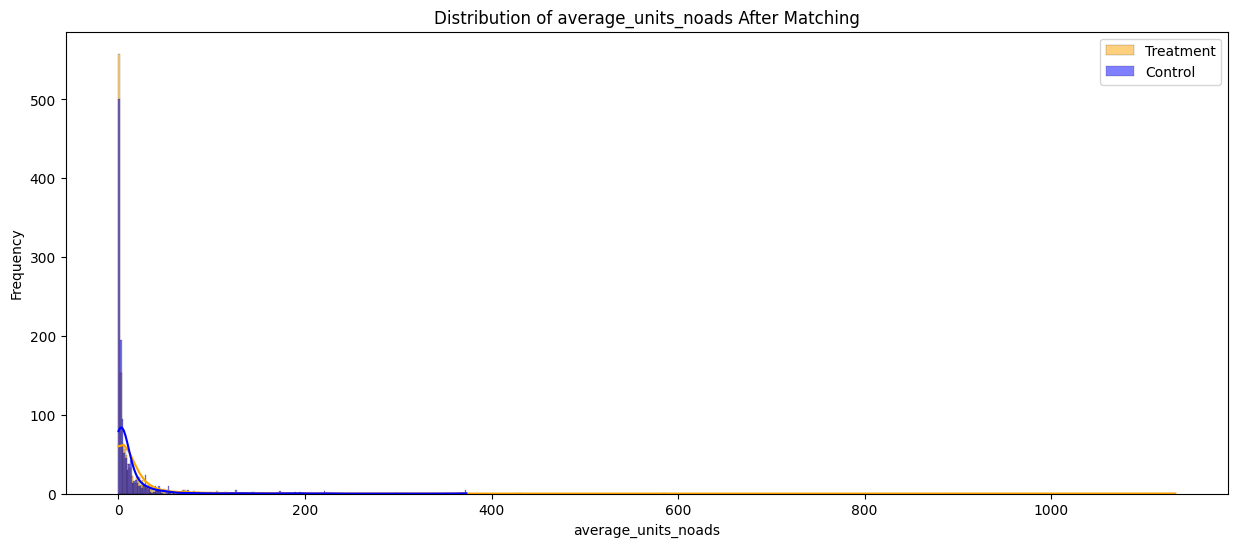

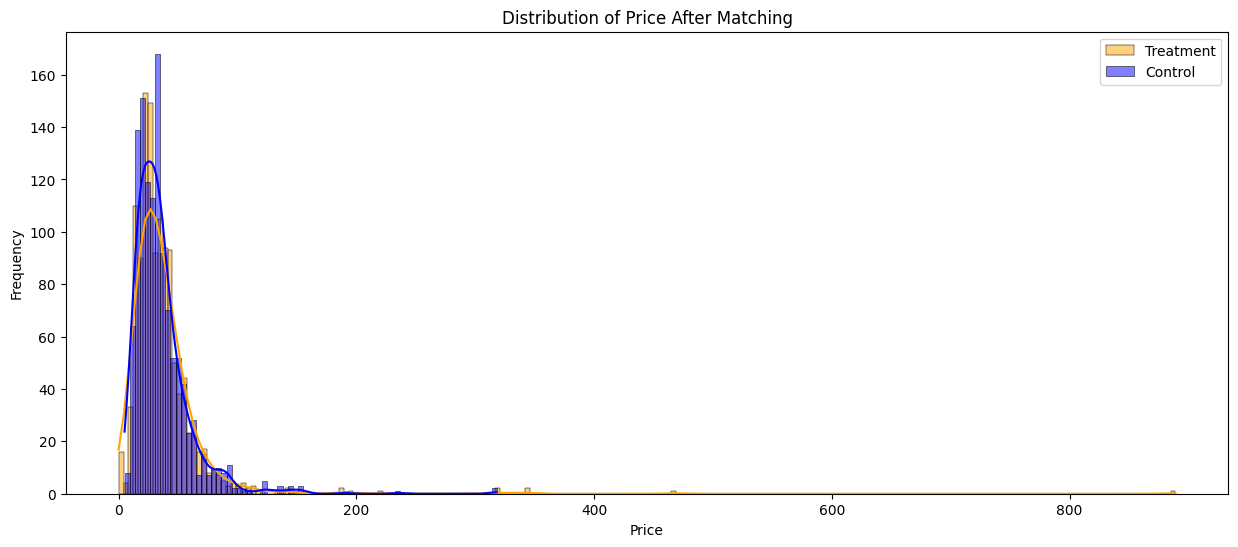

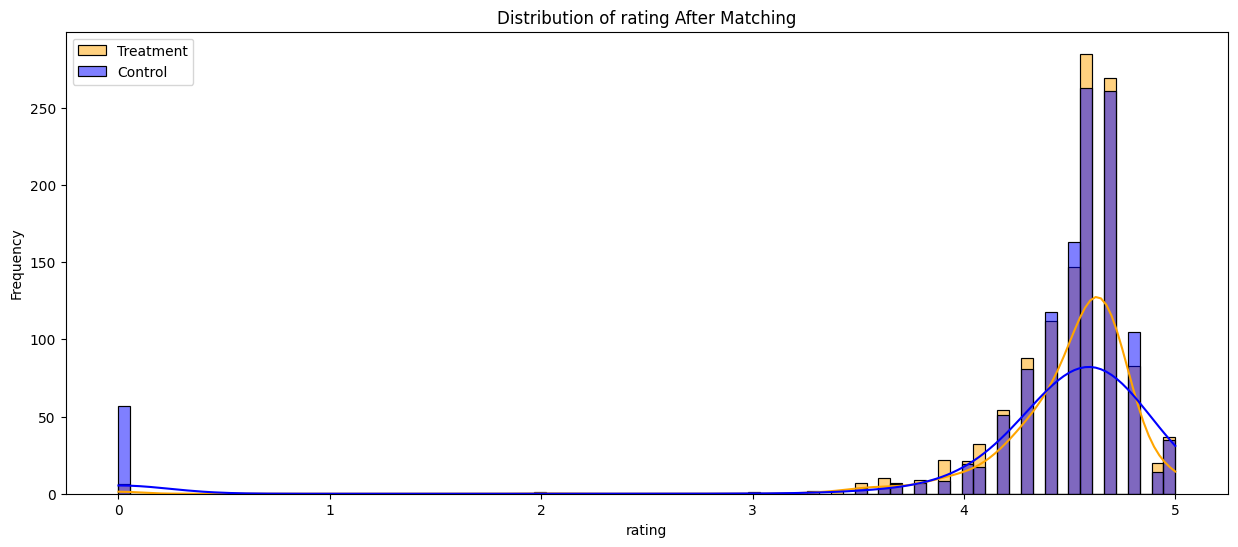

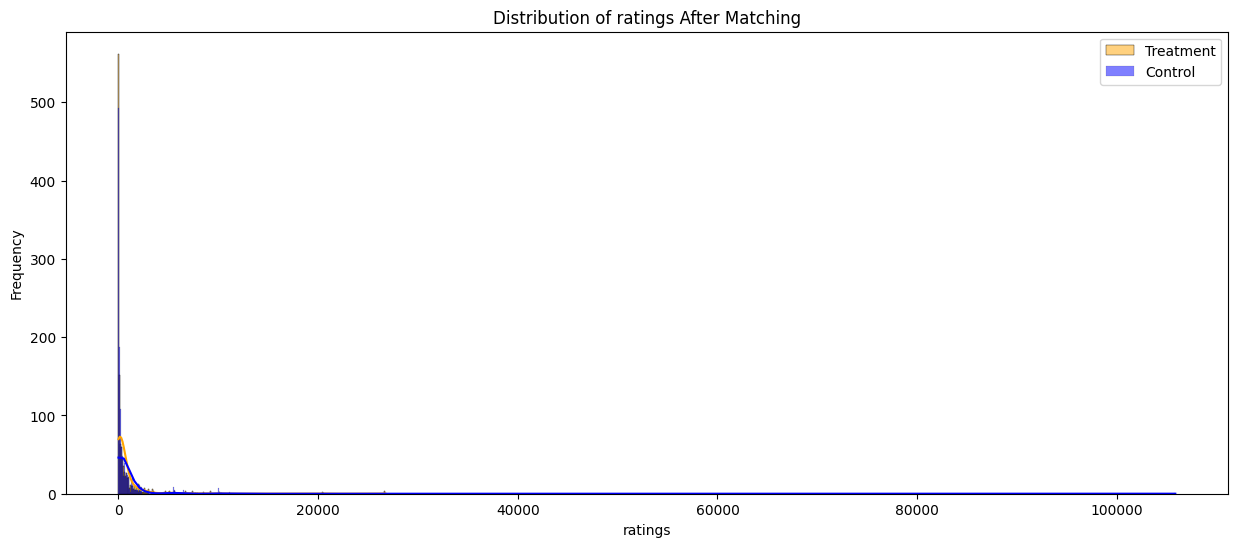

In [131]:
# Logistic
with open('/Volumes/Samsung_T5/Data/Applied Project/matched_data_HH_lr.pkl', 'rb') as f:
    matched_data_HH_lr = pickle.load(f)
with open('/Volumes/Samsung_T5/Data/Applied Project/best_model_HH_lr.pkl', 'rb') as f:
    best_model_HH_lr = pickle.load(f)
check_balance(matched_data_HH_lr, 'average_units_noads')
check_balance(matched_data_HH_lr, 'Price')
check_balance(matched_data_HH_lr, 'rating')
check_balance(matched_data_HH_lr, 'ratings')

##### Clothing, Shoes & Jewelry

In [132]:
category = 'Clothing, Shoes & Jewelry'
matched_data_CSJ_lr, best_model_CSJ_lr = get_matched_data(category)
best_model_CSJ_lr

LogisticRegression(C=0.01, solver='liblinear')

T-Test Result - average_units_noads:
T-Statistic: 0.7939
P-Value: 0.4274
The feature "average_units_noads" shows no significant difference after matching.

T-Test Result - Price:
T-Statistic: 1.1266
P-Value: 0.2602
The feature "Price" shows no significant difference after matching.

T-Test Result - rating:
T-Statistic: 0.2668
P-Value: 0.7897
The feature "rating" shows no significant difference after matching.

T-Test Result - ratings:
T-Statistic: -2.1081
P-Value: 0.0353
The feature "ratings" shows a significant difference after matching.



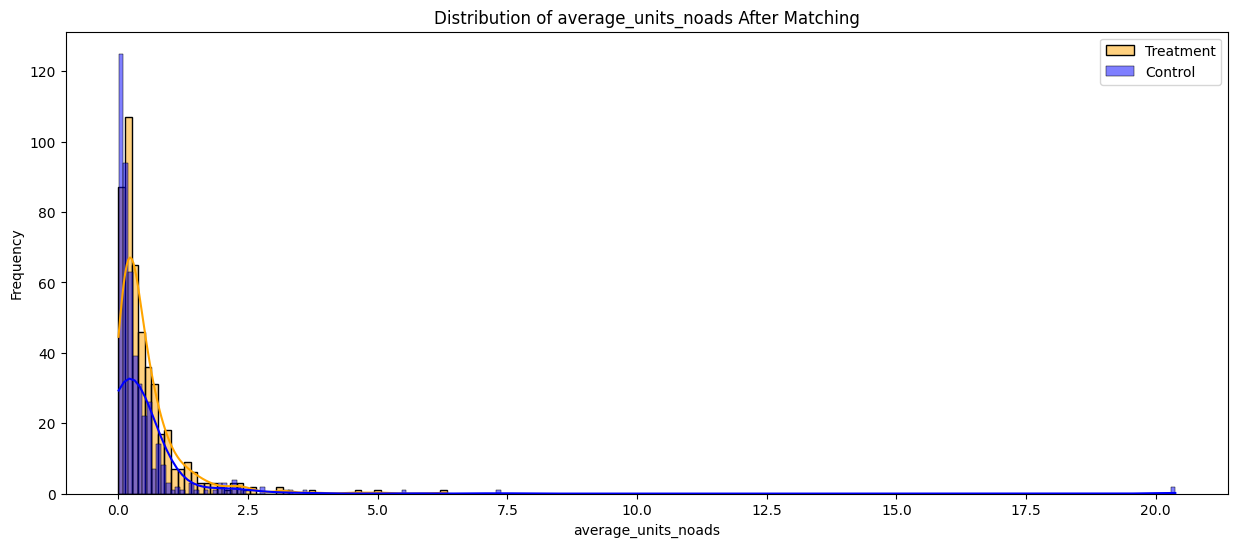

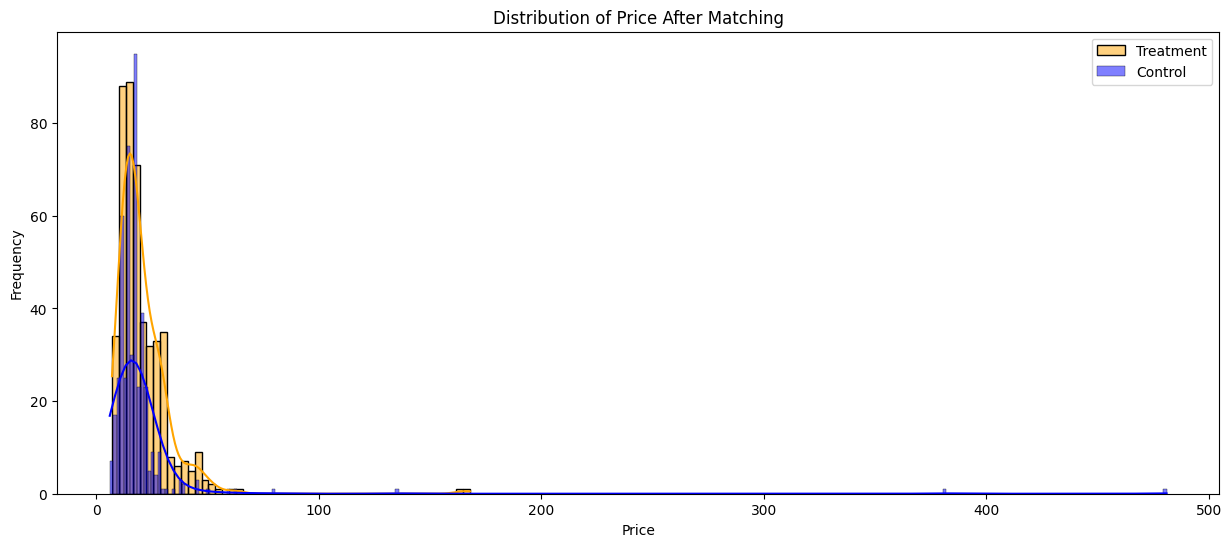

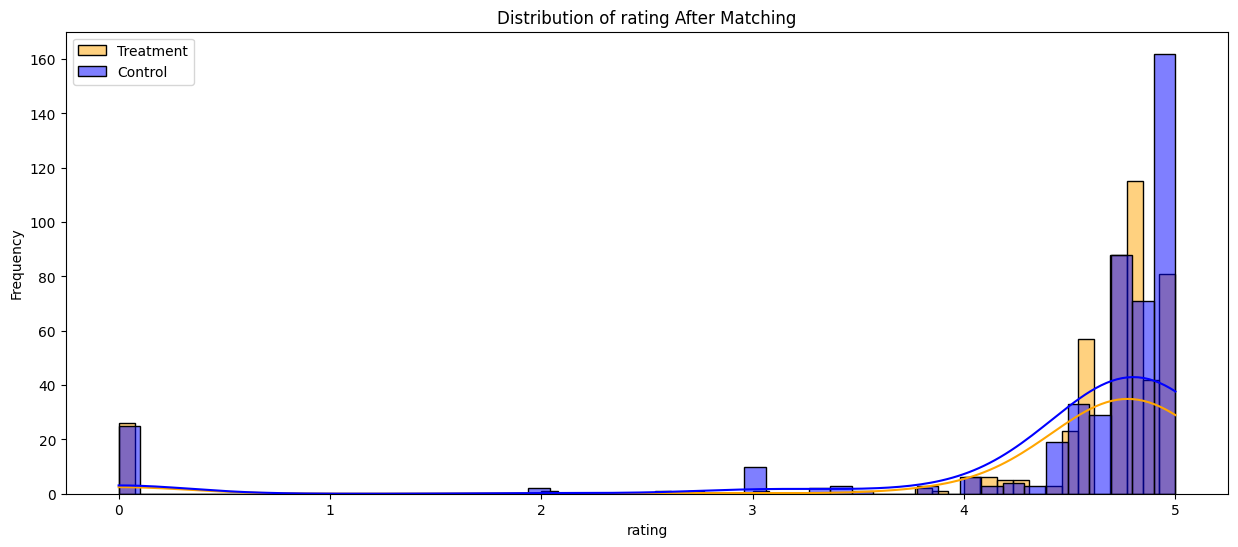

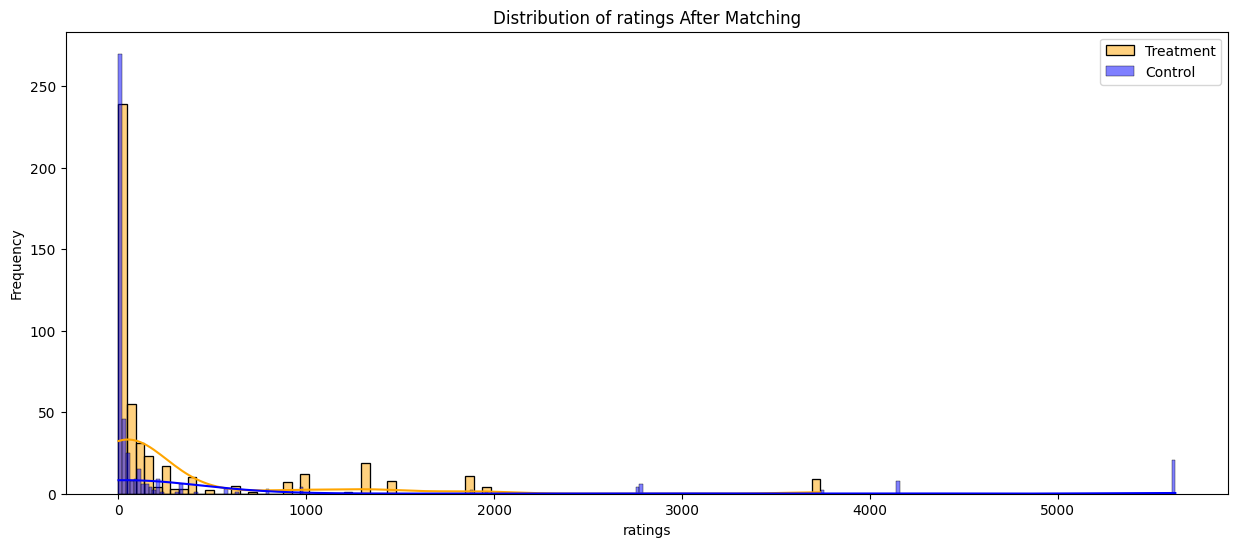

In [133]:
with open('/Volumes/Samsung_T5/Data/Applied Project/matched_data_CSJ_lr.pkl', 'rb') as f:
    matched_data_CSJ_lr = pickle.load(f)
with open('/Volumes/Samsung_T5/Data/Applied Project/best_model_CSJ_lr.pkl', 'rb') as f:
    best_model_CSJ_lr = pickle.load(f)
check_balance(matched_data_CSJ_lr, 'average_units_noads')
check_balance(matched_data_CSJ_lr, 'Price')
check_balance(matched_data_CSJ_lr, 'rating')
check_balance(matched_data_CSJ_lr, 'ratings')

##### Home & Kitchen

In [134]:
category = 'Home & Kitchen'
matched_data_HK_lr, best_model_HK_lr = get_matched_data(category)
best_model_HK_lr

LogisticRegression(C=10.0, penalty='l1', solver='liblinear')

In [135]:
with open('/Volumes/Samsung_T5/Data/Applied Project/matched_data_HK_lr.pkl', 'wb') as f:
    pickle.dump(matched_data_HK_lr, f)
with open('/Volumes/Samsung_T5/Data/Applied Project/best_model_HK_lr.pkl', 'wb') as f:
    pickle.dump(best_model_HK_lr, f) 

T-Test Result - average_units_noads:
T-Statistic: 0.2977
P-Value: 0.7661
The feature "average_units_noads" shows no significant difference after matching.

T-Test Result - Price:
T-Statistic: -2.2635
P-Value: 0.0243
The feature "Price" shows a significant difference after matching.

T-Test Result - rating:
T-Statistic: 2.7222
P-Value: 0.0068
The feature "rating" shows a significant difference after matching.

T-Test Result - ratings:
T-Statistic: 0.5055
P-Value: 0.6135
The feature "ratings" shows no significant difference after matching.



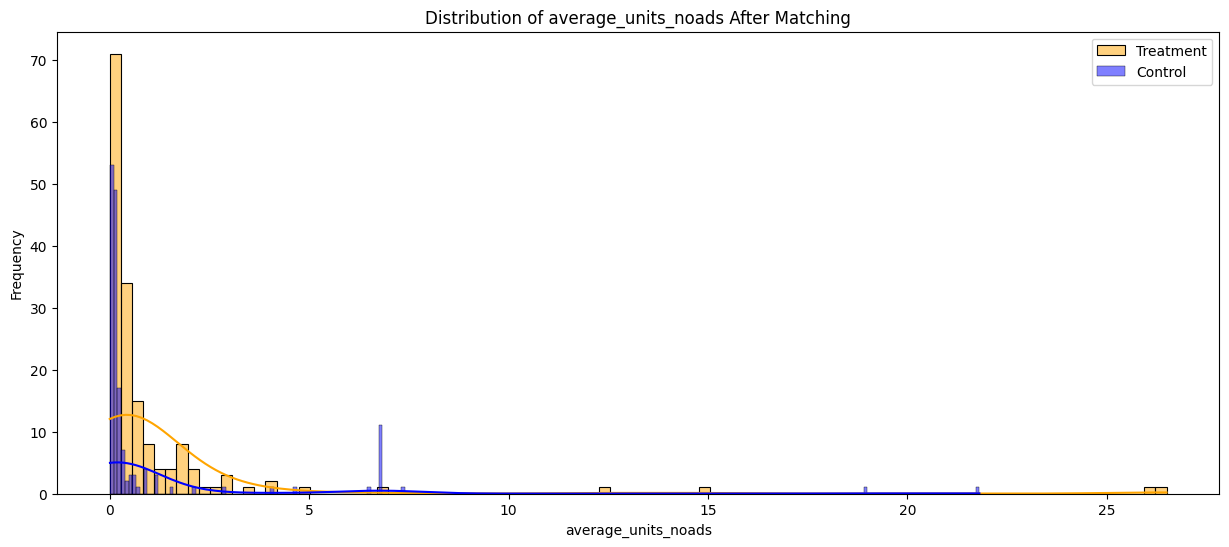

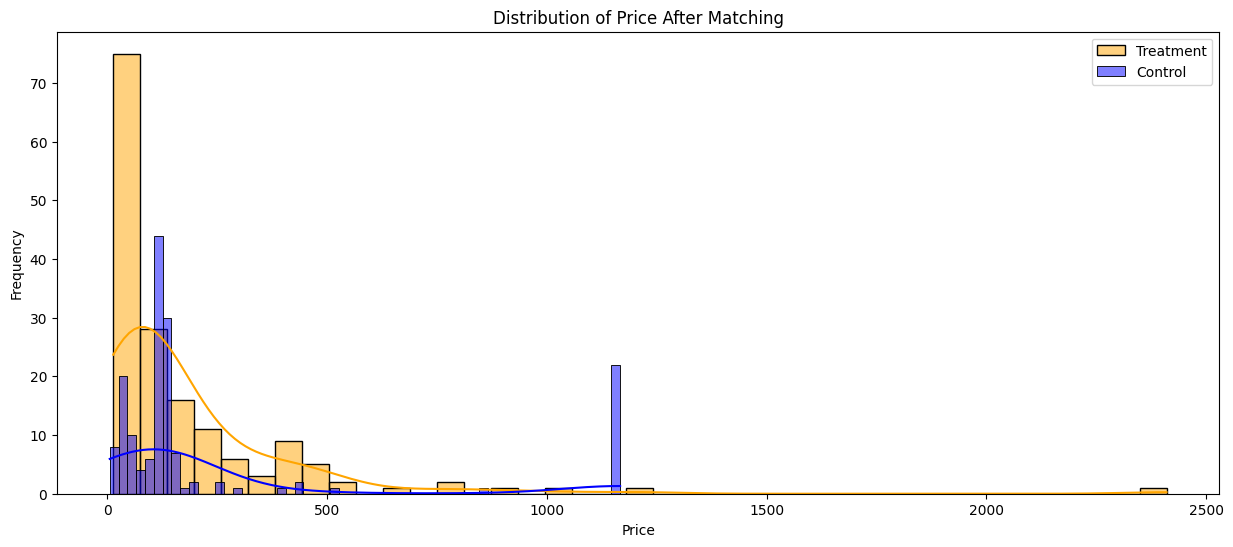

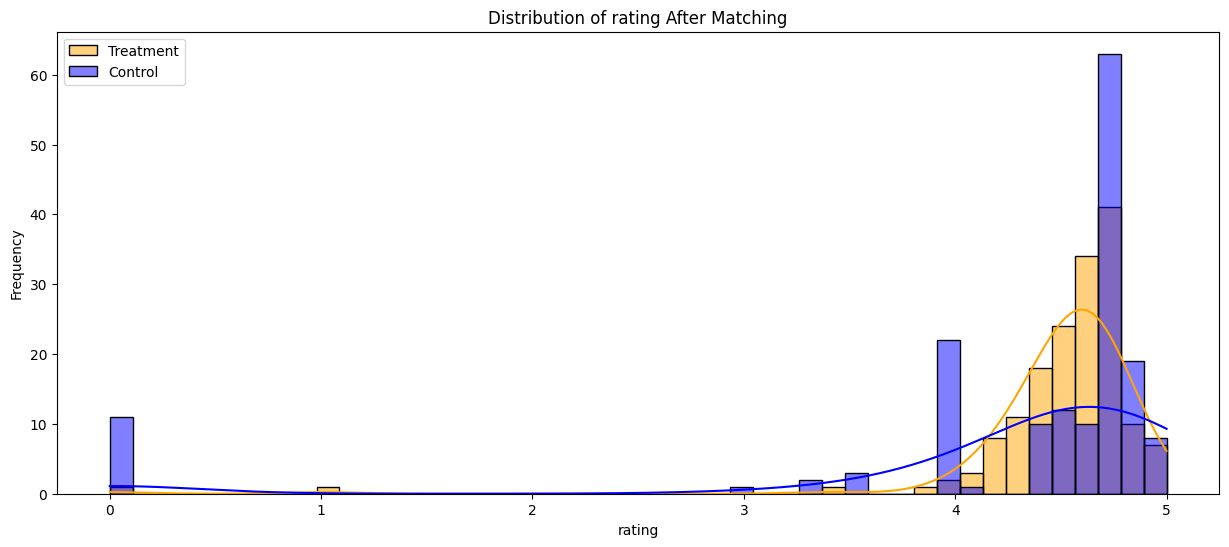

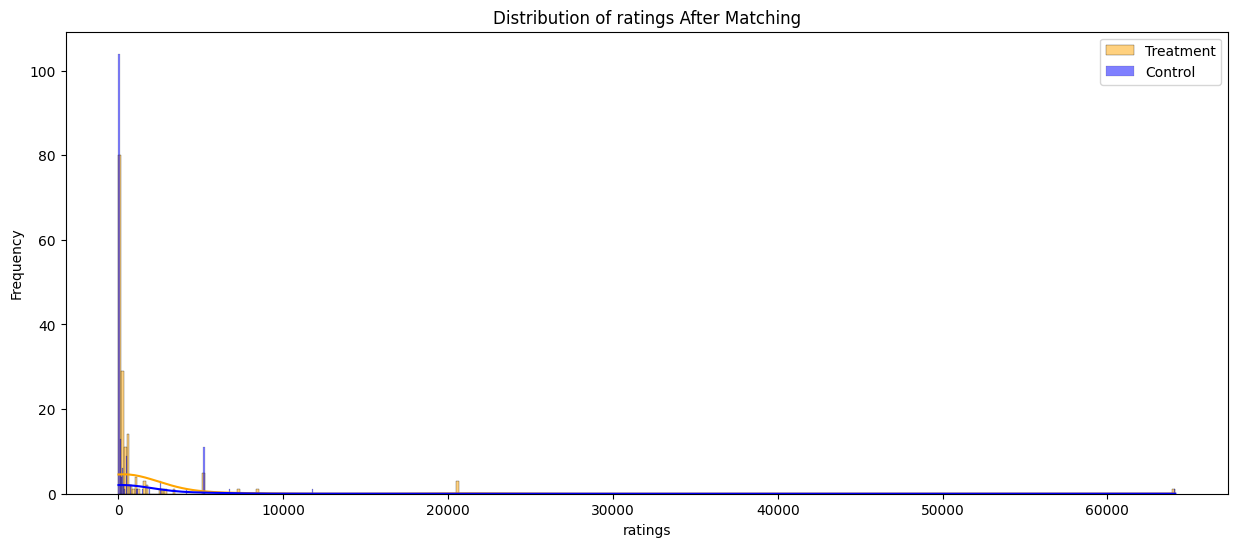

In [136]:
with open('/Volumes/Samsung_T5/Data/Applied Project/matched_data_HK_lr.pkl', 'rb') as f:
    matched_data_HK_lr = pickle.load(f)
with open('/Volumes/Samsung_T5/Data/Applied Project/best_model_HK_lr.pkl', 'rb') as f:
    best_model_HK_lr = pickle.load(f)
check_balance(matched_data_HK_lr, 'average_units_noads')
check_balance(matched_data_HK_lr, 'Price')
check_balance(matched_data_HK_lr, 'rating')
check_balance(matched_data_HK_lr, 'ratings')

### (iv) Compare and Select

In [137]:
HH = pd.merge(Matched_Manual, matched_data_HH_lr[['treatment_asin', 'matched_asin']], on = 'treatment_asin', suffixes=('_manual', '_model'))
CSJ = pd.merge(Matched_Manual, matched_data_CSJ_lr[['treatment_asin', 'matched_asin']], on = 'treatment_asin', suffixes=('_manual', '_model'))
HK = pd.merge(Matched_Manual, matched_data_HK_lr[['treatment_asin', 'matched_asin']], on = 'treatment_asin', suffixes=('_manual', '_model'))

## 4.4 Interact: Test

### (i) Ads Sensitivity Analysis

In [138]:
# Add Category and Brand_id
Ads_Sensitivity_Updated = pd.merge(Ads_Sensitivity, Treatment_Group[['first_category', 'second_category', 'last_category']], left_index = True, right_index = True)
Ads_Sensitivity_Updated = pd.merge(Ads_Sensitivity_Updated, Ads[['asin', 'brand_id']].drop_duplicates(), left_index = True, right_on = 'asin')
Ads_Sensitivity_Updated = Ads_Sensitivity_Updated.set_index('asin')
Ads_Sensitivity_Updated.sort_values(by = 'sensitivity', ascending = False).head(30)

,sensitivity,first_category,second_category,last_category,brand_id
asin,,,,,
B00XBZFWJA,2724.944444,Tools & Home Improvement,Building Supplies,Ventilation Fans,40
B004O2I1Z6,235.428016,Beauty & Personal Care,Skin Care,Creams,44
B07V2BTRY1,205.637931,Tools & Home Improvement,Building Supplies,Ventilation Fans,40
B00OA6NLG0,184.523288,Health & Household,"Vitamins, Minerals & Supplements",Acetyl-L-Carnitine,3
B07VKPJTRG,126.586207,"Clothing, Shoes & Jewelry",Men,Socks,353
B09G8JWQJ4,120.552941,"Clothing, Shoes & Jewelry",Men,Active,353
B00N9E4J3I,97.181818,"Clothing, Shoes & Jewelry",Luggage & Travel Gear,Travel Duffels,356
B00V6MUCL8,94.014451,Health & Household,"Vitamins, Minerals & Supplements",Magnesium,12
B000FGZG3A,92.687223,Health & Household,Diet & Sports Nutrition,Detox & Cleanse,5


#### a. Identify the 'outliers'
- The ads effect of these products are significantly greater than effect of other products.

In [139]:
threshold = 3
temp = Ads_Sensitivity_Updated[~Ads_Sensitivity_Updated['sensitivity'].isin([-1])].dropna()
temp = temp.reset_index()
outliers = temp.groupby(['first_category', 'second_category', 'last_category']).apply(lambda x: x[abs(stats.zscore(x['sensitivity'])) > threshold].sort_values(by='sensitivity', ascending=False)).reset_index(drop = True)
outliers.set_index(['first_category', 'second_category', 'last_category'])

asin  \
first_category            second_category                  last_category                                       
Clothing, Shoes & Jewelry Men                              Athletic Socks                         B07VM9W3TK   
                                                           Athletic Socks                         B08H53C9XD   
                                                           Athletic Socks                         B08R2MRGBL   
                                                           Athletic Socks                         B09G8HPVFX   
                                                           Athletic Socks                         B09PC3C2TQ   
                                                           Boxer Briefs                           B09PC4R4D4   
                                                           Liners & Ankle Socks                   B09G8KVV4S   
                                                           Socks                                  B07VKPJTRG   
                          Novelty & More                   Socks                                  B076Z87LZR   
                          Westlake                         Westlake                               B08ZT14873   
                          Women                            Athletic Socks                         B09L54NW12   
                                                           Socks                                  B09L532SDT   
Health & Household        Diet & Sports Nutrition          Detox & Cleanse                        B000FGZG3A   
                          Vitamins, Minerals & Supplements Adrenal Extracts                       B00J8CEPXE   
                                                           B-Complex                              B000KYSCOM   
                                                           Blended Vitamin & Mineral Supplements  B08HSLQQPD   
                                                           Blended Vitamin & Mineral Supplements  B09BZSVGLV   
                                                           Blended Vitamin & Mineral Supplements  B000Z8BB4Q   
                                                           Blended Vitamin & Mineral Supplements  B009LI7VRC   
                                                           Blended Vitamin & Mineral Supplements  B003PR3OVW   
                                                           CoQ10                                  B01M6A97R0   
                                                           Magnesium                              B00V6MUCL8   
                                                           Milk Thistle                           B000Z597EA   
                                                           Multi-Enzymes                          B005HXOBFA   
                                                           Multivitamins                          B0929TCDDW   
                                                           Probiotics                             B012E7IV52   
                                                           Turmeric                               B006P8NAHQ   
                                                           Vitamin C                              B0010ED38G   
                                                           Vitamin C                              B000MDY7RC   
                                                           Vitamin D                              B00EPQN6TW   
Home & Kitchen            Kitchen & Dining                 Countertop Blenders                    B00GPRPWAU   
Industrial & Scientific   Fasteners                        Framing Nails                          B002NU6HDY   
Sports & Outdoors         Outdoor Recreation               Camping Stoves                         B007PK9RG6   
Tools & Home Improvement  Building Supplies                Ventilation Fans                       B00XBZFWJA   

                                                                       

### (ii) Test

In [140]:
# Try to find the best matched products based on the cointegration of the sales trend
def analyze_data(asin, data):
    global best_matched
    asin_treat = asin
    try:
        asin_control_model = data[data['treatment_asin'] == asin_treat]['matched_asin_model'].values[0]
        asin_control_manual = data[data['treatment_asin'] == asin_treat]['matched_asin_manual'].values[0]

        plot_total_units(asin_treat, asin_control_model, asin_control_manual)
        best_matched, result = calculate_cointegration(asin_treat, data)
        print('\n', '########## Matching Result ##########')
        print('Best matching asin:', best_matched)
        print('Cointegration statistic:', result[0])
        print('p-value:', result[1])
    except IndexError: # We only trained HH / CSJ/ HK
        print('No matching record found for the given ASIN.')
        
        
asin_input = widgets.Text(description='ASIN:')
data_dropdown = widgets.Dropdown(options=['HH', 'CSJ', 'HK'], description='Category:')

def analyze_button_clicked(button):
    asin_value = asin_input.value
    data = data_dropdown.value
    
    if data == 'HH':
        analyze_data(asin_value, HH)
    elif data == 'CSJ':
        analyze_data(asin_value, CSJ)
    elif data == 'HK':
        analyze_data(asin_value, HK)

analyze_button = widgets.Button(description = 'Analyze')
analyze_button.on_click(analyze_button_clicked)

display(asin_input, data_dropdown, analyze_button) # B09G8KVV4S	


Text(value='', description='ASIN:')

Dropdown(description='Category:', options=('HH', 'CSJ', 'HK'), value='HH')

Button(description='Analyze', style=ButtonStyle())

### (iii) DID Model

In [141]:
asin_treat = asin_input.value
asin_control = best_matched

NameError: name 'best_matched' is not defined

In [ ]:
DID_treat = Ads_Agg[Ads_Agg.asin == asin_treat][['asin', 'date', 'units_total']]
DID_Control = Sales[Sales['asin'] == asin_control].sort_values(by = 'date')[['asin', 'date', 'units_total']]

DID_treat_subset = DID_treat[DID_treat['date'].isin(DID_Control['date'])]
DID_Control_subset = DID_Control[DID_Control['date'].isin(DID_treat['date'])]

DID = pd.concat([DID_treat_subset, DID_Control_subset], axis = 0)
DID['treat'] = (DID['asin'] == asin_treat).astype(int)
DID = pd.merge(DID, Ads_Agg[Ads_Agg.asin == asin_treat][['date', 'ads']], on = 'date')
model = smf.ols(formula = 'units_total ~ treat*ads', data = DID).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            units_total   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     100.3
Date:                Wed, 14 Jun 2023   Prob (F-statistic):           6.34e-47
Time:                        02:23:15   Log-Likelihood:                -112.57
No. Observations:                 356   AIC:                             233.1
Df Residuals:                     352   BIC:                             248.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0533      0.026      2.074      0.039       0.003       0.104
treat         -0.0118      0.036     -0.326      0.745      -0.083       0.060
ads           -0.0533      0.114     -0.466      0.641      -0.278       0.171
treat:ads      2.0118      0.162     12.456      0.000       1.694       2.329
==============================================================================
Omnibus:                      391.942   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29046.687
Skew:                           4.661   Prob(JB):                         0.00
Kurtosis:                      46.259   Cond. No.                         12.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [142]:
# Wrape
def DID_analyze(asin_treat, asin_control):
    DID_treat = Ads_Agg[Ads_Agg.asin == asin_treat][['asin', 'date', 'units_total']]
    DID_Control = Sales[Sales['asin'] == asin_control].sort_values(by = 'date')[['asin', 'date', 'units_total']]

    DID_treat_subset = DID_treat[DID_treat['date'].isin(DID_Control['date'])]
    DID_Control_subset = DID_Control[DID_Control['date'].isin(DID_treat['date'])]

    DID = pd.concat([DID_treat_subset, DID_Control_subset], axis = 0)
    DID['treat'] = (DID['asin'] == asin_treat).astype(int)
    DID = pd.merge(DID, Ads_Agg[Ads_Agg.asin == asin_treat][['date', 'ads']], on = 'date')
    
    model = smf.ols(formula='units_total ~ treat * ads', data=DID).fit()
    
    print('\n', '########## Products Selected ##########')
    print('Treatment ASIN:', asin_treat)
    print('Control ASIN:', asin_control)
    print('\n', '########## Model Result ##########')
    print('Coefficients:')
    print(model.params[3])
    print('P-values:')
    p_val = model.pvalues[3]
    if p_val < 0.001:
        print(p_val, '=> ***')
    elif p_val < 0.01:
        print(p_val, '=> **')
    elif p_val < 0.05:
        print(p_val, '=> *')
    else:
        print(p_val)
    print('R-squared:')
    print(model.rsquared)

### (iv) Robustness Test
- Find two consecutive intervals with duration >= 7

In [143]:
# Tests Combination
# Normality Test -> Levene's Test -> Paired Sample Test
# Not Normal / Not Equal Variance -> Wilcoxon Signed-Rank Test
def paired_sample_test(data, breakpoint):
    data_before = data[data['date'] < breakpoint]['units_total']
    data_after = data[data['date'] >= breakpoint]['units_total']
    # Shapiro-Wilk Test
    _, p_value_shapiro1 = stats.shapiro(data_before)
    _, p_value_shapiro2 = stats.shapiro(data_after)

    if p_value_shapiro1 < 0.05 or p_value_shapiro2 < 0.05:
        print('The assumption of normality is violated.')
        # Wilcoxon Signed-Rank Test
        print('Wilcoxon Signed-Rank Test:')
        w_statistic, p_value_wilcox = stats.wilcoxon(data_before, data_after)
        if p_value_wilcox < 0.05:
            print('There is a statistically significant difference between the two paired samples.')
        else:
            print('No statistically significant difference is observed.')
        return p_value_wilcox, w_statistic
    else:
        # Levene's Test
        _, p_value_levene = stats.levene(data_before, data_after)
        if p_value_levene < 0.05:
            print('The assumption of homogeneity of variances is violated.')
            # Wilcoxon Signed-Rank Test
            print('Wilcoxon Signed-Rank Test:')
            w_statistic, p_value_wilcox = stats.wilcoxon(data_before, data_after)
            if p_value_wilcox < 0.05:
                print('There is a statistically significant difference between the two paired samples.')
            else:
                print('No statistically significant difference is observed.')
            return p_value_wilcox, w_statistic
        else:
            # Paired Sample t-test 
            print('Paired sample t test:')
            t_statistic, p_value_ttest = stats.ttest_rel(data_before, data_after)
            if p_value_ttest < 0.05:
                print('There is a statistically significant difference between the two paired samples.')
            else:
                print('No statistically significant difference is observed.')
            return p_value_ttest, t_statistic

In [149]:
def robustness_test(asin_treat, best_matched, bp, bandwidth):
    breakpoint = datetime.strptime(bp, '%Y-%m-%d')
    print(asin_treat)
    print(best_matched)
    sales_test_treat = Sales[(Sales['asin'] == asin_treat) & 
                            (Sales['date'] >= breakpoint - timedelta(bandwidth)) &
                            (Sales['date'] <= breakpoint + timedelta(bandwidth - 1))].sort_values(by = 'date')
    sales_test_control = Sales[(Sales['asin'] == best_matched ) & 
                            (Sales['date'] >= breakpoint - timedelta(bandwidth)) &
                            (Sales['date'] <= breakpoint + timedelta(bandwidth - 1))].sort_values(by = 'date')
    print(paired_sample_test(sales_test_treat, breakpoint))
    print('\n')
    print(paired_sample_test(sales_test_control, breakpoint))

## 4.5 Demo

Text(value='', description='ASIN:')

Dropdown(description='Category:', options=('HH', 'CSJ', 'HK'), value='HH')

Button(description='Analyze', style=ButtonStyle())

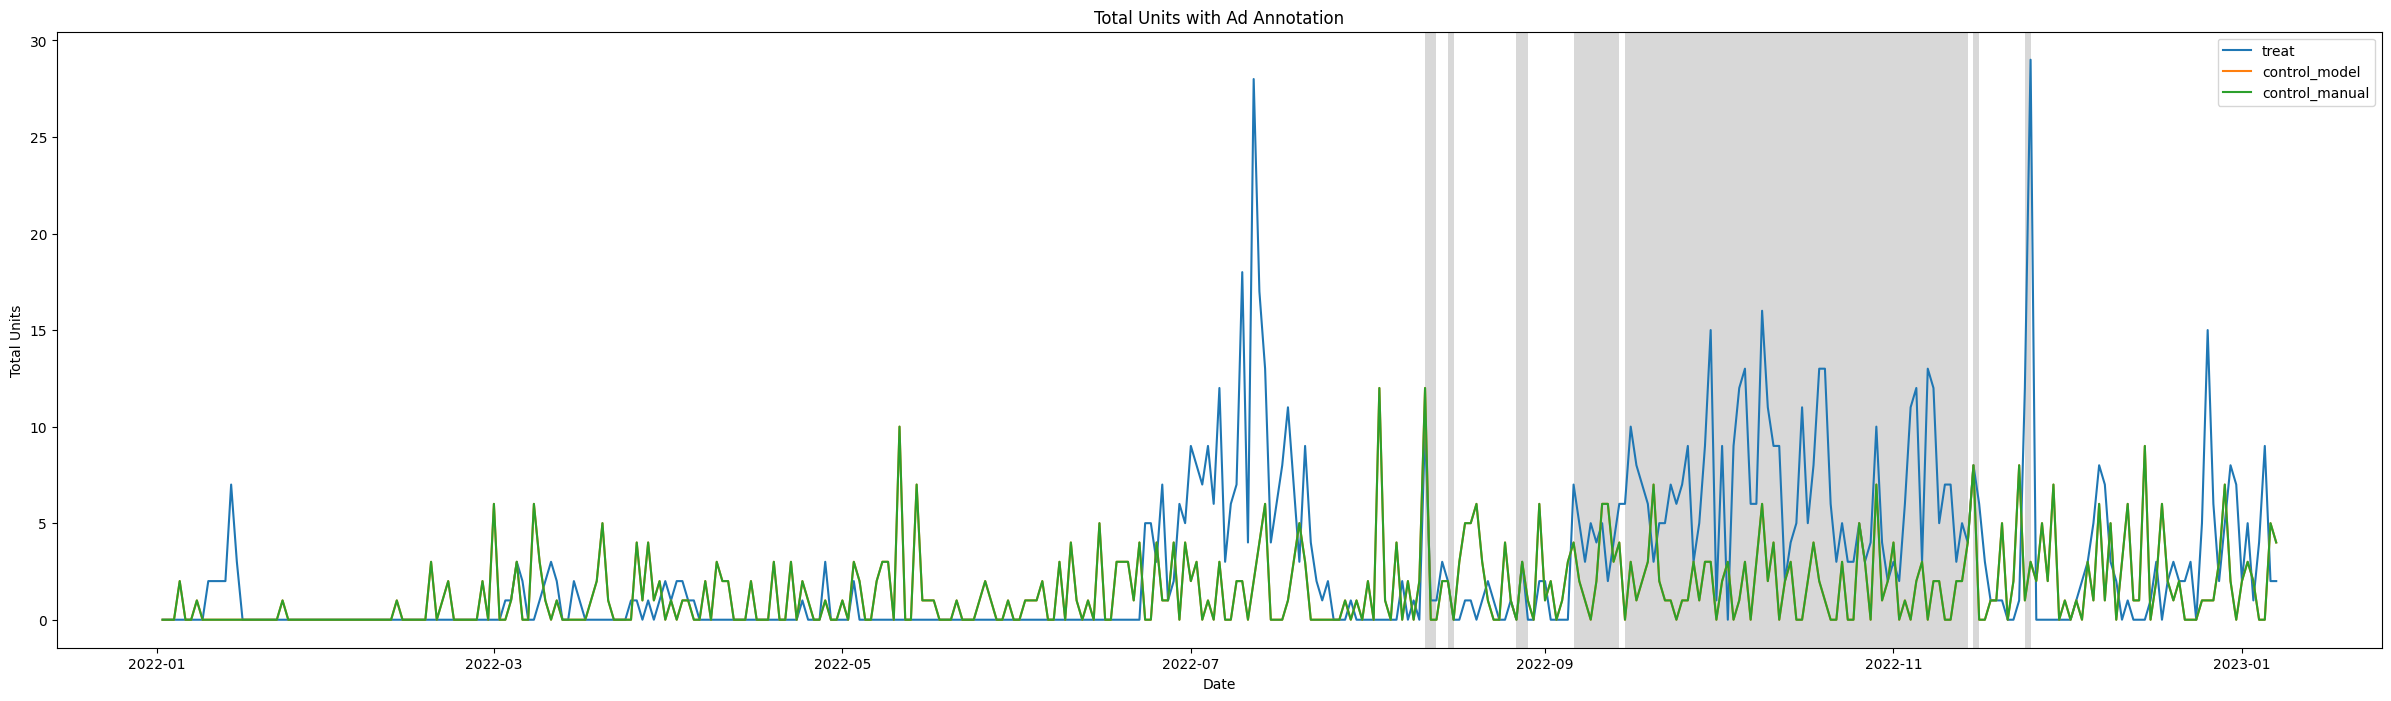

same
Best matching asin: B07H3DB43D
Cointegration statistic: -3.6088670931259146
p-value: 0.023889359316253987

 ########## Products Selected ##########
Treatment ASIN: B08DL3S2D6
Control ASIN: B07H3DB43D

 ########## Model Result ##########
Coefficients:
4.3721677074041105
P-values:
2.864921191604353e-16 => ***
R-squared:
0.23563414963475038


In [ ]:
# Wrape Up
asin_treat = None
best_matched = None
# Try to find the best matched products based on the cointegration of the sales trend
def analyze_data(asin, data):
    global best_matched
    asin_treat = asin
    try:
        asin_control_model = data[data['treatment_asin'] == asin_treat]['matched_asin_model'].values[0]
        asin_control_manual = data[data['treatment_asin'] == asin_treat]['matched_asin_manual'].values[0]

        plot_total_units(asin_treat, asin_control_model, asin_control_manual)
        best_matched, result = calculate_cointegration(asin_treat, data)
        print('Best matching asin:', best_matched)
        print('Cointegration statistic:', result[0])
        print('p-value:', result[1])
    except IndexError: # We only trained HH / CSJ/ HK
        print('No matching record found for the given ASIN.')
        
        
asin_input = widgets.Text(description='ASIN:')
data_dropdown = widgets.Dropdown(options=['HH', 'CSJ', 'HK'], description='Category:')

def analyze_button_clicked(button):
    global asin_treat
    asin_value = asin_input.value
    data = data_dropdown.value
    asin_treat = asin_value
    
    if data == 'HH':
        analyze_data(asin_value, HH)
    elif data == 'CSJ':
        analyze_data(asin_value, CSJ)
    elif data == 'HK':
        analyze_data(asin_value, HK)
        
    # DID Results
    DID_analyze(asin_value, best_matched)
    
analyze_button = widgets.Button(description = 'Analyze')
analyze_button.on_click(analyze_button_clicked)

display(asin_input, data_dropdown, analyze_button) 
# CSJ: B09G8KVV4S / B09PC462RY / B08DL3S2D6
# HH:  B091G58KQX /B000FLF9NM / B0010ED38G / B07Q2M4634
# HK:  B06XPZV1NZ: X / B095BRZYP2


In [147]:

get_segments(Ads_Agg, asin_treat)

,Start,End,Segment Type,Duration,Sales
0,2022-01-02,2022-08-10,no ads,221.0,297.0
1,2022-08-11,2022-08-12,ads,2.0,11.0
2,2022-08-13,2022-08-14,no ads,2.0,4.0
3,2022-08-15,2022-08-15,ads,1.0,2.0
4,2022-08-16,2022-08-26,no ads,11.0,7.0
5,2022-08-27,2022-08-28,ads,2.0,3.0
6,2022-08-29,2022-09-05,no ads,8.0,4.0
7,2022-09-06,2022-09-13,ads,8.0,35.0
8,2022-09-14,2022-09-14,no ads,1.0,6.0
9,2022-09-15,2022-11-13,ads,60.0,410.0


In [150]:
robustness_test(asin_treat, best_matched, '2022-09-06', 7)

B08DL3S2D6
B07H3DB43D
The assumption of normality is violated.
Wilcoxon Signed-Rank Test:
There is a statistically significant difference between the two paired samples.
(0.015625, 0.0)


Paired sample t test:
No statistically significant difference is observed.
(0.39321139020718054, -0.9196819982872166)
